# Terrain Preprocessing - Keenan's Power Data
### Created by Keenan McConkey 2019.08.01

In [1]:
from __future__ import absolute_import, division, print_function

import pandas as pd

import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal
from scipy import stats

from datetime import datetime
from decimal import Decimal

import pymrmr
import sklearn

## Part 1 - Importing Datasets

### Part (0) - Functions for Data Import

In [2]:
# Easier to read column names
std_columns = ['X Accel', 'Y Accel', 'Z Accel', 'X Gyro', 'Y Gyro', 'Z Gyro', 'Run Time', 'Epoch Time']
data_columns =  ['X Accel', 'Y Accel', 'Z Accel', 'X Gyro', 'Y Gyro', 'Z Gyro']
synthesis_columns = ['Calc X Accel', 'Calc X Vel', 'Calc Z Gyro', 'Run Time', 'Epoch Time',
                     'Left X Accel', 'Left Y Accel', 'Left Z Accel', 'Left XY Accel', 
                     'Left X Gyro','Left Y Gyro', 'Left Z Gyro',
                     'Right X Accel', 'Right Y Accel', 'Right Z Accel', 'Right XY Accel',
                     'Right X Gyro', 'Right Y Gyro', 'Right Z Gyro']

# Columns not currently used
unused_columns = ['Time Received', 'Timestamp', 'Pitch (Deg)', 'Roll (Deg)', 'Heading (Deg)',
                  'MagX', 'MagY', 'MagZ']

'''Get columns for given label'''
def get_columns(_label):
    
    # Columns are different for synthesis data
    if 'Middle' in _label or 'Left' in _label or 'Right' in _label:
        columns = std_columns.copy()
    elif 'Synthesis' in _label:
        columns = synthesis_columns.copy()
    else:
        raise Exception('Unknown label')
    
    # For transformed datasets replace time columns with frequency
    if 'FFT' in _label or 'PSD' in _label:
        columns.remove('Epoch Time')
        
        if 'Run Time' in columns:
            columns.remove('Run Time')
        
        columns.append('Frequency')
        
    return columns

In [3]:
# Types of terrains, placements, and transforms used
terrains = ['Concrete', 'Carpet', 'Linoleum', 'Asphalt', 'Sidewalk', 'Grass', 'Gravel']
placements = ['Left', 'Right', 'Middle', 'Synthesis']
transforms = ['FFT', 'PSD', 'PSDLog']
movements = ['F8', 'Donut', 'Straight']

'''Get the integer terrain value of a given label'''
def get_terrain_num(_label):
    for i, terrain in enumerate(terrains):
        if terrain in _label:
            return i
        
    raise Exception('Unknown terrain')

'''Get the name associated with a terrain integer'''
def get_terrain_name(terrain_num):
    return terrains[terrain_num]
    return terrains[terrain_num]

'''Get the placement location name for given label'''
def get_placement(_label):
    for placement in placements:
        if placement in _label:
            return placement
    
    raise Exception('Unknown placement')

'''Get the transform used for given label'''
def get_transform(_label):
    for transform in transforms:
        if transform in _label:
            return transform
    
    raise Exception('Unkown transform')

### Part (a) - Parsing Data into Pandas

In [4]:
# Find .csv files
raw_datasets = {}
dataset_labels = []
dataset_paths = glob.glob('imu_data/new_setup/set_power/*.csv')

# Remove 9250 IMU data (for now)
for path in dataset_paths.copy():
    if 'Jamie' in path or 'Kevin' in path or 'Mahsa' in path or '9250' in path:
        dataset_paths.remove(path)

In [5]:
# Import datasets as a dictionary of Pandas DataFrames
for dataset_path in dataset_paths:
    
    # Parse labels from filenames
    dataset_label = dataset_path.split('/')[-1].split('.')[0]    
    dataset_labels.append(dataset_label)

    # Read from CSV to Pandas
    dataset = pd.read_csv(dataset_path)

    # Drop unused columns
    unused = [unused_column for unused_column in unused_columns if unused_column in dataset.columns]
    dataset = dataset.drop(unused, axis='columns')
    
    # Rename columns to something easier to work with
    dataset.columns = get_columns(dataset_label)

    # Convert timestamps to epoch time in s
    dataset['Epoch Time'] = dataset['Epoch Time'].apply(datetime.strptime, args=("%Y-%m-%d %H:%M:%S:%f", ))
    dataset['Epoch Time'] = dataset['Epoch Time'].apply(datetime.timestamp)
    
    # Remove gravitational acceleration from Middle data
    ## Can't remove from wheel-mounted Left and Right data because they rotate over time
    if 'Middle' in dataset_label:
        # Remove gravity from z component of acceleration, 
        g_z = 9.81
        dataset['Z Accel'] = dataset['Z Accel'].apply(lambda x: x - g_z)

    # Remove dropped bytes - i.e. run times below zero
    #dataset = dataset.drop(dataset.loc[dataset['Run Time'] < 0].index.values.tolist())

    # Reorganize synthesis data columns
    if 'Synthesis' in dataset_label:
        dataset_columns = dataset.columns.tolist()
        dataset_columns = dataset_columns[:3] + dataset_columns[5:] + dataset_columns[3:5]
        dataset = dataset[dataset_columns]
    
    # Trim edges to account for start and end time
    STARTUP_THRESH = 2.0
    
    # Different axes to check threshold for synthesis data
    if 'Synthesis' in dataset_label:
        thresh_axes = 'Calc X Accel'
    else:
        thresh_axes = 'Z Accel'
        
    # Caluclate first and last instance above threshold and use at time range
    start_index = dataset[dataset[thresh_axes] > STARTUP_THRESH].index[0]
    stop_index = dataset[dataset[thresh_axes] > STARTUP_THRESH].index[-1]
    dataset = dataset[start_index:stop_index]
    
    # Datasets are stored in a dictionary
    raw_datasets.update({dataset_label: dataset})

In [6]:
# Update order of synthesis columns
synthesis_columns = ['Calc X Accel', 'Calc X Vel', 'Calc Z Gyro',
                     'Left X Accel', 'Left Y Accel', 'Left Z Accel', 'Left XY Accel', 
                     'Left X Gyro','Left Y Gyro', 'Left Z Gyro',
                     'Right X Accel', 'Right Y Accel', 'Right Z Accel', 'Right XY Accel',
                     'Right X Gyro', 'Right Y Gyro', 'Right Z Gyro',
                     'Run Time', 'Epoch Time',]

In [7]:
# List all datasets
dataset_labels

['Middle_GravelPowerF8_Module6050',
 'Middle_GrassPowerF8_Module6050',
 'Middle_AsphaltPowerDonut_Module6050',
 'Middle_SidewalkPowerF8_Module6050',
 'Middle_CarpetPowerF8_Module6050',
 'Middle_ConcretePowerDonut_Module6050',
 'Middle_GrassPowerStraight_Module6050',
 'Middle_ConcretePowerStraight_Module6050',
 'Middle_GravelPowerDonut_Module6050',
 'Middle_CarpetPowerDonut_Module6050',
 'Middle_LinoleumPowerF8_Module6050',
 'Middle_LinoleumPowerDonut_Module6050',
 'Middle_SidewalkPowerStraight_Module6050',
 'Middle_SidewalkPowerDonut_Module6050',
 'Middle_LinoleumPowerStraight_Module6050',
 'Middle_CarpetPowerStraight_Module6050',
 'Middle_AsphaltPowerF8_Module6050',
 'Middle_GrassPowerDonut_Module6050',
 'Middle_GravelPowerStraight_Module6050',
 'Middle_AsphaltPowerStraight_Module6050',
 'Middle_ConcretePowerF8_Module6050']

In [8]:
# Check dataset formatting
raw_datasets[dataset_labels[0]].head()

,X Accel,Y Accel,Z Accel,X Gyro,Y Gyro,Z Gyro,Run Time,Epoch Time
2087,3.651014,-2.060040,2.142943,-0.051896,0.050352,-0.872442,6.959993,1.564094e+09
2088,-5.314929,-3.547180,3.464845,-0.013270,-0.073515,-0.980592,6.963118,1.564094e+09
2089,2.338691,-2.268384,0.569592,-0.202401,-0.273833,-0.846603,6.966132,1.564094e+09
2090,6.507950,1.074687,-3.012953,0.142829,-0.044213,-0.982191,6.969387,1.564094e+09
2091,-5.698089,-2.048067,0.059511,-0.055359,-0.157425,-0.956618,6.972963,1.564094e+09


### Part (b) - Visualizing Time Domain Data

In [9]:
'''Plot a single dataset in one direction'''
def plot_one(_datasets, dataset_name, x_axis, y_axis, xlim=None, ylim=None, save_fig=False):
    plt.clf()
    plt.figure(figsize=(10, 5))
    
    plt.plot(_datasets[dataset_name][x_axis], _datasets[dataset_name][y_axis])
    plt.title(dataset_name)
    plt.xlabel(x_axis + ' (s)')
    
    if 'Accel' in y_axis:
        plt.ylabel(y_axis + ' ($m/s^2$)')
    elif 'Gyro' in y_axis:
        plt.ylabel(y_axis + ' ($rad/s$)')
    elif 'Vel' in y_axis:
        plt.ylabel(y_axis + ' ($m/s$)')
    else:
        plt.ylabel('Unknown')
    
    if xlim is not None:
        plt.xlim(xlim[0], xlim[1])
    
    if ylim is not None:
        plt.ylim(ylim[0], ylim[1])
    
    # Save figure to png file without plotting
    if save_fig:
        save_name = '/home/caris/Wheelchair-Terrain-Classification/imgs/'
        save_name = save_name + y_axis.replace(' ', '_') + '_' + dataset_name + '.png'
        plt.savefig(save_name)
    
    # Just plot without saving
    else:    
        plt.show()

<Figure size 432x288 with 0 Axes>

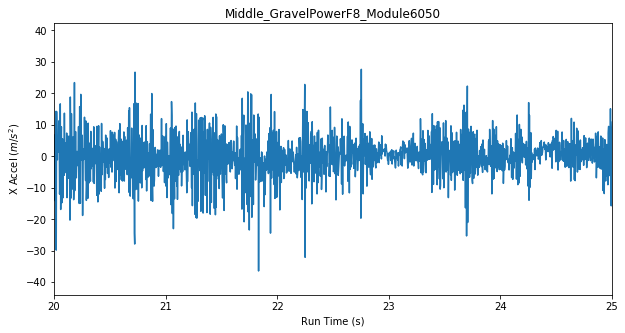

In [10]:
# Plot some raw data
plot_one(raw_datasets, dataset_labels[0], 'Run Time', 'X Accel', xlim=(20, 25))

In [11]:
# Plot every dataset Z Accel and save images
#for label in dataset_labels:
#    plot_one(raw_datasets, label, 'Run Time', 'Z Accel', save_fig=True)

In [12]:
'''Compare two Pandas DataFrames by Epoch Time'''
def dataset_compare(dataset1, label1, dataset2, label2, dirn, t_offset=0, y_offset=0):
    plt.clf()
    fig, ax = plt.subplots(figsize=(20, 5))
    
    # Plot data with given y and t offsetson first dataset
    ax.plot(dataset1[label1]['Epoch Time'].apply(lambda t: t + t_offset), 
            dataset1[label1][dirn].apply(lambda y: y + y_offset), label=label1)
    ax.plot(dataset2[label2]['Epoch Time'], 
            dataset2[label2][dirn], label=label2)
    
    ax.set_xlabel('Epoch Time ($s$)')
    if 'Gyro' in dirn:
        ax.set_ylabel(dirn + ' ($rad/s$)')
    elif 'Accel' in dirn:
        ax.set_ylabel(dirn + ' ($m/s^2$)')
    
    ax.set_title(dirn + ' for ' + label1 + ' and ' + label2)
    
    # Plot offset info
    offset_text = 'Offsets\n'
    offset_text += ': t={}'.format(t_offset) + ', ' + 'y={}'.format(y_offset)
    ax.text(0.05, 0.05, s=offset_text, 
            horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)
    
    ax.legend()
    plt.show()

In [13]:
# Compare Z Gyro data for each wheel in the same dataset
#dataset_compare(raw_datasets, 'Left_ConcreteStraight_Module',
#                raw_datasets, 'Right_ConcreteStraight_Module', 
#                dirn='Z Gyro')

In [14]:
'''Plot given x and y axes for every Pandas DataFrame in given array of datasets'''
def plot_all(_datasets, x_axis, y_axis, windowed=False, win_num=0, take_row=False):
    plt.clf()
    
    n_axes = len(_datasets)
    odd_axes = n_axes % 2 == 1
    
    rows = int((n_axes + 1) / 2)
    
    # Scale approriately
    if (odd_axes):
        fig = plt.figure(figsize=(n_axes*5, n_axes*3))          
    else:
        fig = plt.figure(figsize=(n_axes*5, n_axes*2))
    
    # Grid of subplots
    gs = gridspec.GridSpec(rows, 2)
        
    axes = []
    row, col = 0, 0
    
    for i, (label, dataset) in enumerate(_datasets.items()):
        # Take a whole row if odd num of axes
        if (i == n_axes-1 and odd_axes and take_row): 
            axes.append(fig.add_subplot(gs[row, :]))
        else:
            axes.append(fig.add_subplot(gs[row, col]))
        
        # Plot on new subplot
        if (windowed):
            axes[i].plot(dataset[win_num][x_axis], dataset[win_num][y_axis])
        else:
            axes[i].plot(dataset[x_axis], dataset[y_axis])
        
        axes[i].set_title(label)
        axes[i].set_xlabel(x_axis + ' (s)')
        
        if 'Gyro' in y_axis:
            axes[i].set_ylabel(y_axis + ' ($rad/s$)')
        elif 'Accel' in y_axis:
            axes[i].set_ylabel(y_axis + ' ($m/s^2$)')
        
        # Only go two columns wide
        col += 1
        if (col == 2):
            row += 1
            col = 0
        
    plt.subplots_adjust(hspace=0.35, wspace=0.15)
    plt.show()

<Figure size 432x288 with 0 Axes>

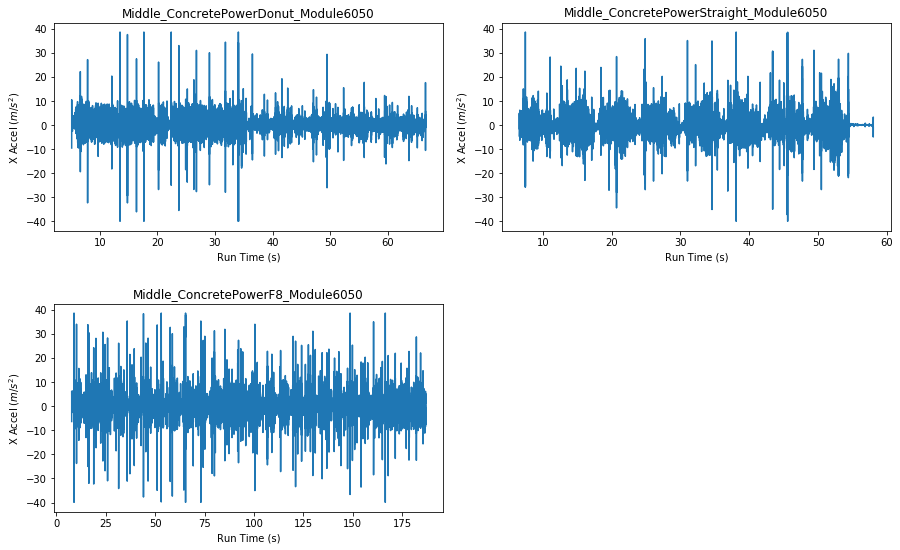

In [15]:
# Plot Z Accel of same dataset for different modules
datasets_to_plot = {label: dataset for label, dataset in raw_datasets.items() if 'Concrete' in label}
plot_all(datasets_to_plot, x_axis='Run Time', y_axis='X Accel')

### Part (c) - Converting Between Pandas and Numpy

In [16]:
'''Convert array of Pandas DataFrames to array of 2D Numpy array'''
def pd_to_np(pd_datasets, windowed=False):
    np_datasets = {}
    
    for label, dataset in pd_datasets.items():
        np_dataset = []
        
        # Return passed datasets if they are already NumPy ndarrays
        if type(dataset) is np.ndarray:
            print('Note: Already a NumPy array!')
            return pd_datasets
        
        # If windowed, convert individual windows to Pandas
        if (windowed):
            for window in dataset:
                np_dataset.append(window.as_matrix()) 
        else:
            np_dataset = dataset.to_numpy()
        
        np_datasets.update({label: np_dataset})
        
    return np_datasets

In [17]:
'''Convert array of 2D Numpy arrays to Pandas Data Frames'''
def np_to_pd(np_datasets, windowed=False):
    pd_datasets = {}
    
    for label, dataset in np_datasets.items():
        pd_dataset = []
        
        # Return passed datasets if they are already Pandas dataframes
        if type(dataset) is pd.DataFrame:
            print('Note: Already a Pandas dataframe!')
            return np_datasets
        
        # Use correct column names
        new_columns = get_columns(label)
            
        # If windowed, convert individual windows to Pandas
        if (windowed):
            for window in dataset:
                pd_dataset.append(pd.DataFrame(data=window, columns=new_columns))
                
        else:
            pd_dataset = pd.DataFrame(data=dataset, columns=new_columns)
            
        pd_datasets.update({label: pd_dataset})
    
    return pd_datasets

In [18]:
# Convert to NumPy
raw_datasets = pd_to_np(raw_datasets)

In [19]:
# Run to convert back to Pandas
#raw_datasets = np_to_pd(raw_datasets)

In [20]:
# Check if its constructed correctly
print('Number of datasets: {}'.format(len(raw_datasets)))
print('Shape of first dataset: {}'.format(raw_datasets[dataset_labels[0]].shape))

Number of datasets: 21
Shape of first dataset: (54144, 8)


#### Data Structure:

`Terrain Dataset Dictionary 
-> NP Array
---> Row = Datapoint, 
---> Col = Direction | Time`

## Part 2 - Preprocessing

In [21]:
'''Get relevant frequencies for given label based on whether its a frame or wheel dataset'''
def get_frequencies(label):
    # Sampling frequency (and thus cutoff frequency) varies between frame and wheel modules
    if 'Left' in label or 'Right' in label or 'Synthesis' in label:
        f_samp = 333.3 # Sampling frequency
        f_low = 60 # Low pass cutoff frequency
        f_high = 1 # High pass cutoff frequency
    elif 'Middle' in label:
        f_samp = 300 # Sampling frequency
        f_low = 55 # Low pass cutoff frequency
        f_high = 1 # High pass cutoaff frequency
    else:
        raise Exception('Unknown label format')
        
    return f_samp, f_low, f_high

In [22]:
'''Get window size based on whether label is for a frame or wheel dataset'''
def get_window_size(label):
    if 'Left' in label or 'Right' in label or 'Synthesis' in label:
        window_size = 333
    elif 'Middle' in label:
        window_size = 300
    else:
        raise Exception('Unknown label format')
    return window_size

In [23]:
def get_n_data_col(label):
    if 'Synthesis' in label:
        n_col = 17
    elif 'Left' in label or 'Right' in label or 'Middle' in label:
        n_col = 6
    else:
        raise Exception('Unknown label format')
    return n_col

### Part (a) - Butterworth Filtering

Butterworth filters can be high-pass/low-pass/bandpass, and attempt to have maximally flat frequency response in bandpass.

Changing the *cutoff frequency* of the filter affects the smoothness of the graph and amount of ringing. 

Changing the *order* of the filter can have significant effects on smoothness depending on the cutoff frequency. 

**Nominally set to 30 % of Nyquist Freq**

In [24]:
# Filtered datasets dictionary
datasets = {}

for label, raw_dataset in raw_datasets.items():
    
    # Sampling rates are not consistent across all datasets
    f_samp, f_low, f_high = get_frequencies(label)
    
    # Get normalized frequencies
    w_low = f_low / (f_samp / 2) 
    w_high = f_high / (f_samp / 2)

    # Get Butterworth filter parameters
    b_butter, a_butter = signal.butter(N=4, Wn=w_low, btype='low')
    
    # Number of columns containing data
    n_data_col = get_n_data_col(label)
    
    # Filter all the data columns
    dataset = np.copy(raw_dataset)
    for i in range(n_data_col):
        dataset[:, i] = signal.filtfilt(b_butter, a_butter, raw_dataset[:, i])
        
    datasets.update({label: dataset})

<Figure size 432x288 with 0 Axes>

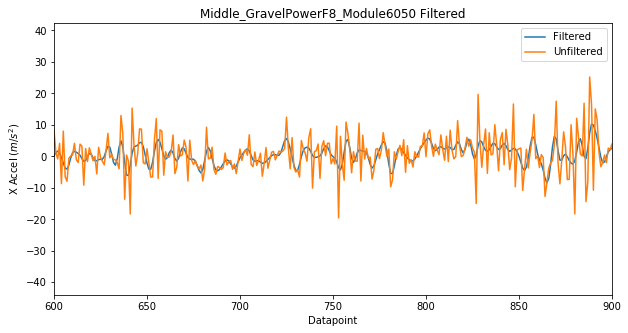

In [25]:
# Compare filtered and unfiltered
plt.clf()
plt.figure(figsize=(10, 5))
plt.plot(datasets[dataset_labels[0]][:, 0], label='Filtered')
plt.plot(raw_datasets[dataset_labels[0]][:, 0], label='Unfiltered')
plt.xlim(600, 900)
plt.legend()
plt.xlabel('Datapoint')
plt.ylabel('X Accel ($m/s^2$)')
plt.title(dataset_labels[0] + ' Filtered')
plt.show()

In [26]:
## Check construction
print('Num filtered datasets: {}'.format(len(datasets)))
print('Shape of first filtered dataset: {}'.format(datasets[dataset_labels[0]].shape))

Num filtered datasets: 21
Shape of first filtered dataset: (54144, 8)


In [27]:
# Verify we can convert back to Pandas
np_to_pd(datasets, windowed=False)[dataset_labels[0]].head()

,X Accel,Y Accel,Z Accel,X Gyro,Y Gyro,Z Gyro,Run Time,Epoch Time
0,3.651288,-2.056318,2.143612,-0.051849,0.050305,-0.872388,6.959993,1.564094e+09
1,1.172087,-2.777281,2.065380,-0.093508,-0.086970,-0.910613,6.963118,1.564094e+09
2,-0.133029,-2.261406,1.152775,-0.086571,-0.186306,-0.937351,6.966132,1.564094e+09
3,-0.041473,-0.459719,-0.829347,-0.011665,-0.207745,-0.944723,6.969387,1.564094e+09
4,0.643823,1.259772,-3.183139,0.097903,-0.122083,-0.933773,6.972963,1.564094e+09


<Figure size 432x288 with 0 Axes>

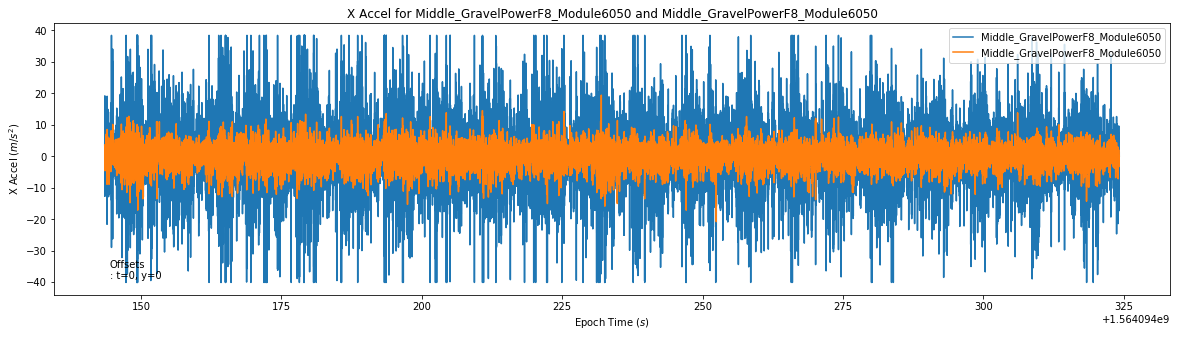

In [28]:
# Again compare filtered and unfiltered data
dataset_compare(np_to_pd(raw_datasets), dataset_labels[0], 
                np_to_pd(datasets), dataset_labels[0], 'X Accel')

### Part (b) - Further Time Domain Visualization

In [29]:
'''Compare Z Gyro of frame to calculated value off of two wheels'''
def gyro_compare(dataset, label, xlim=None):
    plt.clf()
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Calculate Z Gyro off of wheels
    r_wheel = 0.30
    d_base = 0.54
    calc = (r_wheel / d_base)*(-1 * dataset['Left_' + label]['Z Gyro'] - dataset['Right_' + label]['Z Gyro'])
    calc = np.reshape(calc, dataset['Right_' + label]['Epoch Time'].shape)
    
    # Plot actual frame gyro, calculated frame gyro, and actual wheel gyro
    ax.plot(dataset['Middle_' + label]['Epoch Time'], dataset['Middle_' + label]['Z Gyro'], 
            label='Actual Frame')
    ax.plot(dataset['Right_' + label]['Epoch Time'], calc, label='Calculated Frame')
    ax.plot(dataset['Left_' + label]['Epoch Time'], dataset['Left_' + label]['Z Gyro'], 
            label='Actual L Wheel')
    ax.plot(dataset['Right_' + label]['Epoch Time'], dataset['Right_' + label]['Z Gyro'],
            label='Actual R Wheel')
    
    # Other figure stuff
    ax.set_xlabel('Epoch Time ($s$)')
    ax.set_ylabel('Z Gyro ($m/s^2$)')
    ax.set_title('Comparing Actual to Calculated Z Gyro Data')
    
    if xlim:
        start_time = dataset['Middle_' + label]['Epoch Time'][0]
        ax.set_xlim(xlim[0] + start_time, xlim[1] + start_time)
    ax.legend()
    plt.show()

In [30]:
#gyro_compare(np_to_pd(datasets), 'ConcreteDonutKevin_Module', xlim=(20, 40))

### Part (c) - Integrating Data from Three Modules

In [31]:
# Go through Left and Right datasets and integrate into one dataset
'''
for terrain in terrains:
    for movement in movements:
        # Identifier at end of label
        label_suffix = terrain + movement + '_Module'
        
        # Set index to epoch time for easier time alignment
        left = datasets['Left_' + label_suffix].set_index('Epoch Time')
        right = datasets['Right_' + label_suffix].set_index('Epoch Time')
        middle = datasets['Middle_' + label_suffix + '6050'].set_index('Epoch Time')
        synthesis = datasets['Synthesis_' + label_suffix].set_index('Epoch Time')
        
        # Join the wheel data columns, only where they overlap in Epoch Time
        dataset_wheels = pd.concat([left, right], axis=1, join='inner')
        dataset_wheels = dataset_wheels.reset_index()
        
        # Save as a csv and add to dataset dictionary
        wheels_label = 'Wheels_' + label_suffix
        dataset_wheels.to_csv('imu_data/' + wheels_label + '.csv', index=False)
        datasets.update({wheels_label: dataset_wheels})
        
        # Join data from all the "placements", only where they overlap in Epoch Time
        dataset_all = pd.concat([left, right, middle, synthesis], axis=1, join='inner')
        dataset_all = dataset_all.reset_index()
        
        # Save as csv and add to dictionary
        all_label = 'All_' + label_suffix
        dataset_all.to_csv('imu_data/' + all_label + '.csv')
        datasets.update({all_label: dataset_all})
'''

'\nfor terrain in terrains:\n    for movement in movements:\n        # Identifier at end of label\n        label_suffix = terrain + movement + \'_Module\'\n        \n        # Set index to epoch time for easier time alignment\n        left = datasets[\'Left_\' + label_suffix].set_index(\'Epoch Time\')\n        right = datasets[\'Right_\' + label_suffix].set_index(\'Epoch Time\')\n        middle = datasets[\'Middle_\' + label_suffix + \'6050\'].set_index(\'Epoch Time\')\n        synthesis = datasets[\'Synthesis_\' + label_suffix].set_index(\'Epoch Time\')\n        \n        # Join the wheel data columns, only where they overlap in Epoch Time\n        dataset_wheels = pd.concat([left, right], axis=1, join=\'inner\')\n        dataset_wheels = dataset_wheels.reset_index()\n        \n        # Save as a csv and add to dataset dictionary\n        wheels_label = \'Wheels_\' + label_suffix\n        dataset_wheels.to_csv(\'imu_data/\' + wheels_label + \'.csv\', index=False)\n        datasets.up

In [32]:
# Only process new integrated data for now
#datasets = {label: dataset for label, dataset in datasets.items() if 'All' in label or 'Wheels' in label}
#dataset_labels = list(datasets.keys())

## Part 3 - Time Windows

### Part (a) - Creating Time Windowed Data

In [33]:
datasets_windowed = {}

# Trim excess datapoints, then split into windows
for label, dataset in datasets.items():
    window_size = get_window_size(label)
    n_windows = int(len(dataset) / window_size) # Note: Integer floor
    n_points = n_windows * window_size
    
    dataset_windowed = np.resize(dataset, (n_points, dataset.shape[1]))
    dataset_windowed = np.split(dataset_windowed, n_windows, axis=0)
    
    datasets_windowed.update({label: dataset_windowed})

In [34]:
# Check if its constructed correctly
print('Num windowed datasets: {}'.format(len(datasets_windowed)))
print('Num of windows in first dataset: {}'.format(len(datasets_windowed[dataset_labels[0]])))
print('Shape of individual window: {}'.format(datasets_windowed[dataset_labels[0]][0].shape))

Num windowed datasets: 21
Num of windows in first dataset: 180
Shape of individual window: (300, 8)


In [35]:
# Try out pandas conversion again
np_to_pd(datasets_windowed, windowed=True)[dataset_labels[0]][0].tail()

,X Accel,Y Accel,Z Accel,X Gyro,Y Gyro,Z Gyro,Run Time,Epoch Time
295,0.336447,0.213190,-2.125439,-0.065192,0.312537,-1.019069,7.943175,1.564094e+09
296,1.559557,0.017202,-0.508240,-0.032877,0.278266,-0.997443,7.946231,1.564094e+09
297,1.398465,-0.847660,1.579569,0.000300,0.127857,-0.974483,7.950309,1.564094e+09
298,0.614935,-2.043322,2.837419,0.014744,-0.067396,-0.953196,7.953641,1.564094e+09
299,0.428211,-3.107329,2.427930,-0.012746,-0.216303,-0.937120,7.956460,1.564094e+09


<Figure size 432x288 with 0 Axes>

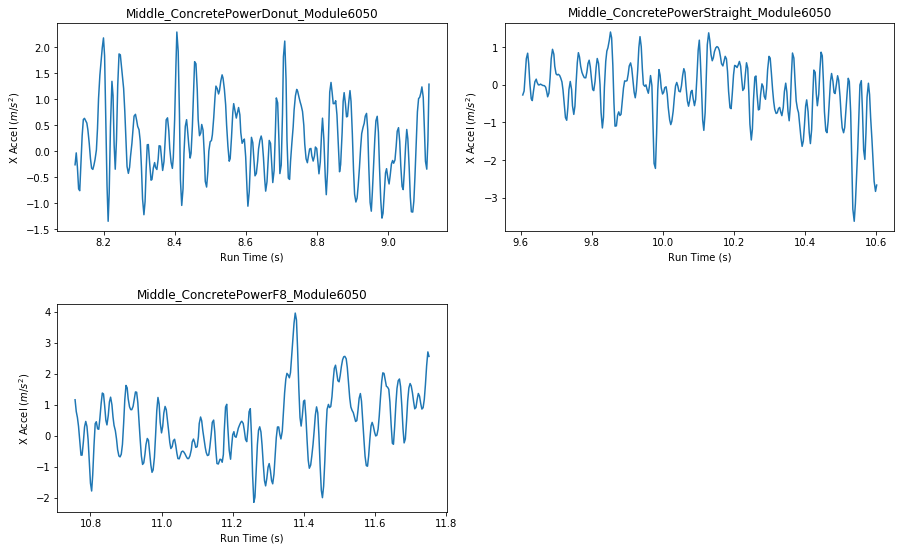

In [36]:
# Plot the first time window
datasets_to_plot = {label: dataset for label, dataset in datasets_windowed.items() if 'Concrete' in label}
plot_all(np_to_pd(datasets_to_plot, windowed=True), 
         x_axis='Run Time', y_axis='X Accel', windowed=True, win_num=3)

#### Data Structure

`Terrain Dataset Dictionary
-> Data Window List
---> NP Array
-----> Row = Datapoint
-----> Col = Direction | Time`

## Part 4 - Transforms

In [37]:
'''Plot tranform of given direction and window of a windowed dataset dictionary'''
def plot_set_transforms(datasets_transformed, dirn, win_num, transform_name):
    plt.clf()
    plt.figure(figsize=(12, 8))
    
    # Plot all the FFTs in one figure overlaid
    for label, dataset in datasets_transformed.items():
        plt.plot(dataset[win_num][:, -1], dataset[win_num][:, dirn], 
                 label=label)
    plt.legend()

    plt.xlabel('Frequency ($Hz$)')
    if (transform_name == 'FFT'):
        plt.ylabel('Amplitude (Normalized to Window Size)')
    elif (transform_name == 'PSD'):
        plt.ylabel('Amplitude (Log-Scaled)')

    plt.title(transform_name +' of ' + get_columns(label)[dirn] + ', Window {}')
    plt.show()

### Part (a) - FFT

In [38]:
datasets_fft = {}
N_BINS_OVER_CUTOFF = 5 # Number of frequency bins past the cutoff frequency to include

# Find the FFT of each column of each data window of each dataset
for label, dataset in datasets_windowed.items():
    dataset_fft = []
    
    for window in dataset:
        # Sampling frequency dependent on device
        f_samp, f_low, f_high = get_frequencies(label)
        
        # Number of columns of data different for synthesis data
        n_data_col = get_n_data_col(label)
        
        # Only include frequency bins up to and a little bit past the cutoff frequency
        # Everything past that is useless because its the same on all terrains
        window_size = get_window_size(label)
        n_bins = int(window_size / f_samp * f_low) + N_BINS_OVER_CUTOFF
        window_fft = np.zeros((n_bins, n_data_col))
        
        for i in range(n_data_col):
            # FFT is normalized to window size, to ensure consistency between different size choices
            window_fft[:, i] = np.resize(np.abs(np.divide(np.fft.fft(window[:, i]), window_size)), n_bins)
            
        # Get positive frequency bins for given FFT parameters
        freq_col = np.transpose([np.resize(np.fft.fftfreq(window_size, 1 / f_samp), n_bins)])
        
        # Append the frequency column
        window_fft = np.append(window_fft, freq_col, axis=1)
        dataset_fft.append(window_fft)
        
    datasets_fft.update({label + 'FFT': dataset_fft})

In [39]:
# Check again if its constructed correctly
print('Num of FFT\'d windowed datasets: {}'.format(len(datasets_fft)))
print('Num of FFT\'d windows in first dataset: {}'.format(len(datasets_fft[dataset_labels[4]+'FFT'])))
print('Shape of FFT\'d individual window: {}'.format(datasets_fft[dataset_labels[4]+'FFT'][0].shape))

# Pandas conversion
np_to_pd(datasets_fft, windowed=True)[dataset_labels[0]+'FFT'][0].head()

Num of FFT'd windowed datasets: 21
Num of FFT'd windows in first dataset: 181
Shape of FFT'd individual window: (60, 7)


,X Accel,Y Accel,Z Accel,X Gyro,Y Gyro,Z Gyro,Frequency
0,0.518220,1.017437,0.027379,0.062467,0.001235,1.161977,0.0
1,0.315330,0.128166,0.034632,0.011407,0.012170,0.037512,1.0
2,0.458880,0.090236,0.140370,0.020925,0.036938,0.025338,2.0
3,0.215495,0.046876,0.063012,0.013192,0.013781,0.038753,3.0
4,0.096985,0.137937,0.059121,0.017016,0.015010,0.037179,4.0


<Figure size 432x288 with 0 Axes>

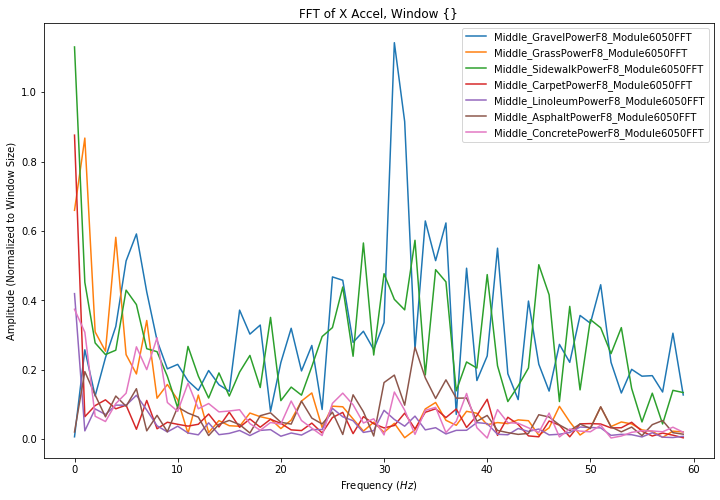

In [40]:
# Plot Middle Z Accel of 10th window
ffts_to_plot = {label: dataset for label, dataset in datasets_fft.items() if 'Middle' in label and 'Straight' not in label and 'Donut' not in label}
plot_set_transforms(ffts_to_plot, win_num=3, dirn=0, transform_name='FFT')

**The number of frequency bins is dependent on window size, and it seems to affect amplitude too.**

<Figure size 432x288 with 0 Axes>

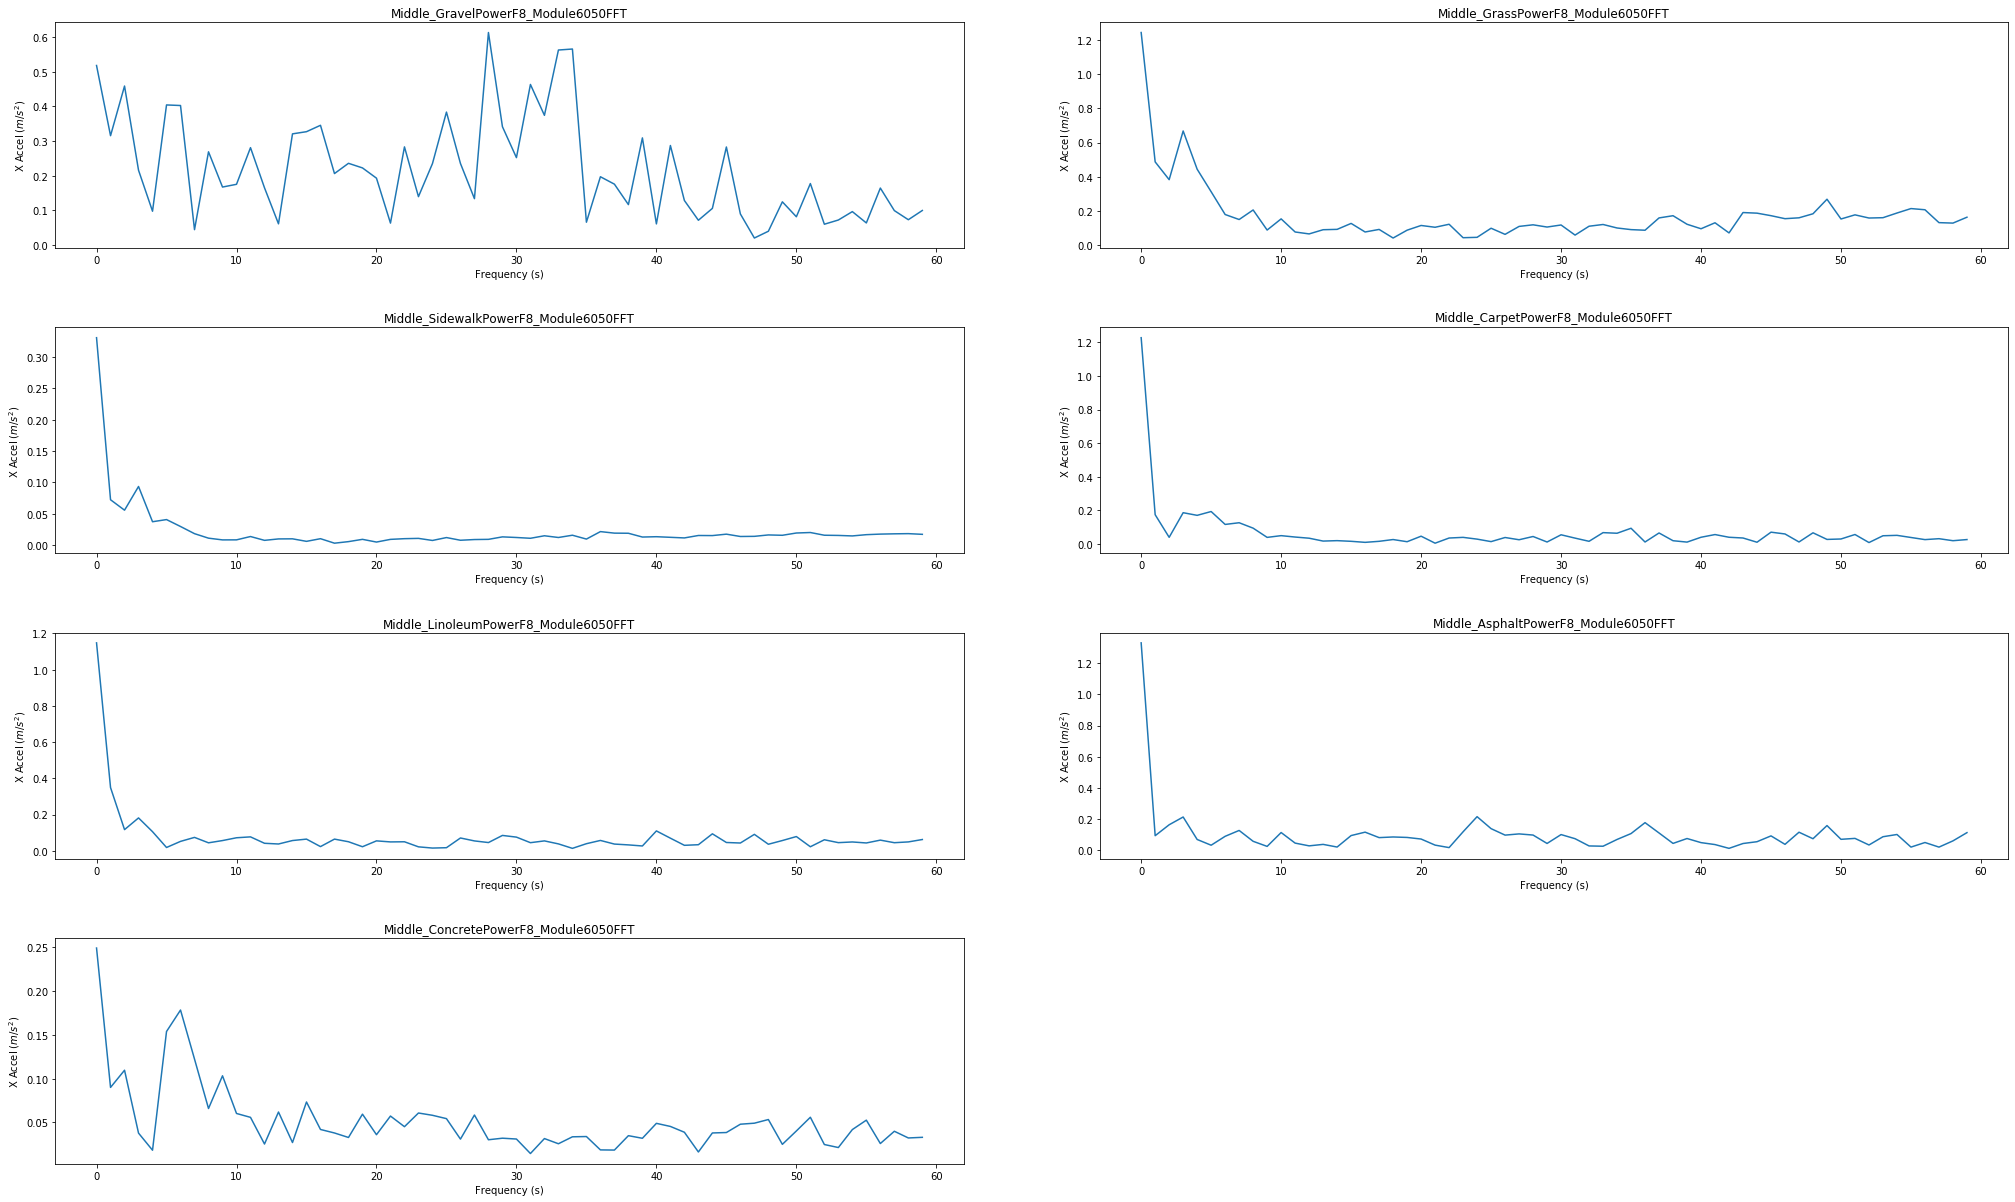

In [41]:
# Plot all the Frame FFTs for 0th window
plot_all(np_to_pd(ffts_to_plot, windowed=True), x_axis='Frequency', y_axis='X Accel', windowed=True)

### Part (b) - PSD

In [42]:
datasets_psd = {}
datasets_psd_log = {}

# Find the PSD and log(PSD) of each column of each data window of each dataset
for label, dataset in datasets_windowed.items():
    dataset_psd = []
    dataset_psd_log = []
    
    for window in dataset:
        # Frequencies depedent on dataset and device used
        f_samp, f_low, f_high = get_frequencies(label)
        
        # Number of columns of data different for synthesis data
        n_data_col = get_n_data_col(label)
        
        # Only include frequency bins up to and a little bit past the cutoff frequency
        # Everything past that is useless because its the same on all terrains
        window_size = get_window_size(label)
        n_bins = int(window_size / f_samp * f_low) + N_BINS_OVER_CUTOFF
        window_psd = np.zeros((n_bins, n_data_col))
        window_psd_log = np.zeros((n_bins, n_data_col))
        
        # Calculate PSD for each axes
        for i in range(n_data_col):
            # Normalized PSD - Returns frequencies and power density
            freq, Pxx = signal.periodogram(window[:, i], f_samp)
            window_psd[:, i] = np.resize(Pxx[1:], n_bins)
            
            # Calculate log10 of PSD, replacing points where PSD = 0 with 0 to avoid division by 0
            for j in range(len(window_psd[:, i])):
                if (window_psd[j, i] == 0):
                    window_psd_log[j, i] = 0
                else:
                    window_psd_log[j, i] = np.log10(window_psd[j, i])
            
        # Append freq column
        freq_col = np.transpose([np.resize(freq[:-1], n_bins)])
        window_psd = np.append(window_psd, freq_col, axis=1)
        window_psd_log = np.append(window_psd_log, freq_col, axis=1)
        
        dataset_psd.append(window_psd)
        dataset_psd_log.append(window_psd_log)
        
    datasets_psd.update({label + 'PSD': dataset_psd})
    datasets_psd_log.update({label +'PSDLog': dataset_psd_log})

In [43]:
# Check again if its constructed correctly
print('Num PSD\'d windowed datasets: {}'.format(len(datasets_psd)))
print('Num of PSD\'d windows in first dataset: {}'.format(len(datasets_psd[dataset_labels[0]+'PSD'])))
print('Shape of PSD\'d individual window: {}'.format(datasets_psd[dataset_labels[0]+'PSD'][0].shape))

Num PSD'd windowed datasets: 21
Num of PSD'd windows in first dataset: 180
Shape of PSD'd individual window: (60, 7)


<Figure size 432x288 with 0 Axes>

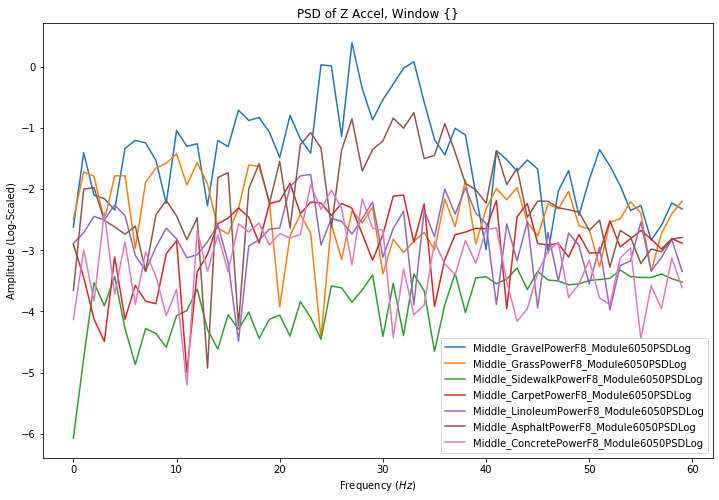

In [45]:
# Plot Z Accel of 0th window
psds_to_plot = {label: dataset for label, dataset in datasets_psd_log.items() if 'Middle' in label and 'Straight' not in label and 'Donut' not in label}
plot_set_transforms(psds_to_plot, win_num=0, dirn=2, transform_name='PSD')

<Figure size 432x288 with 0 Axes>

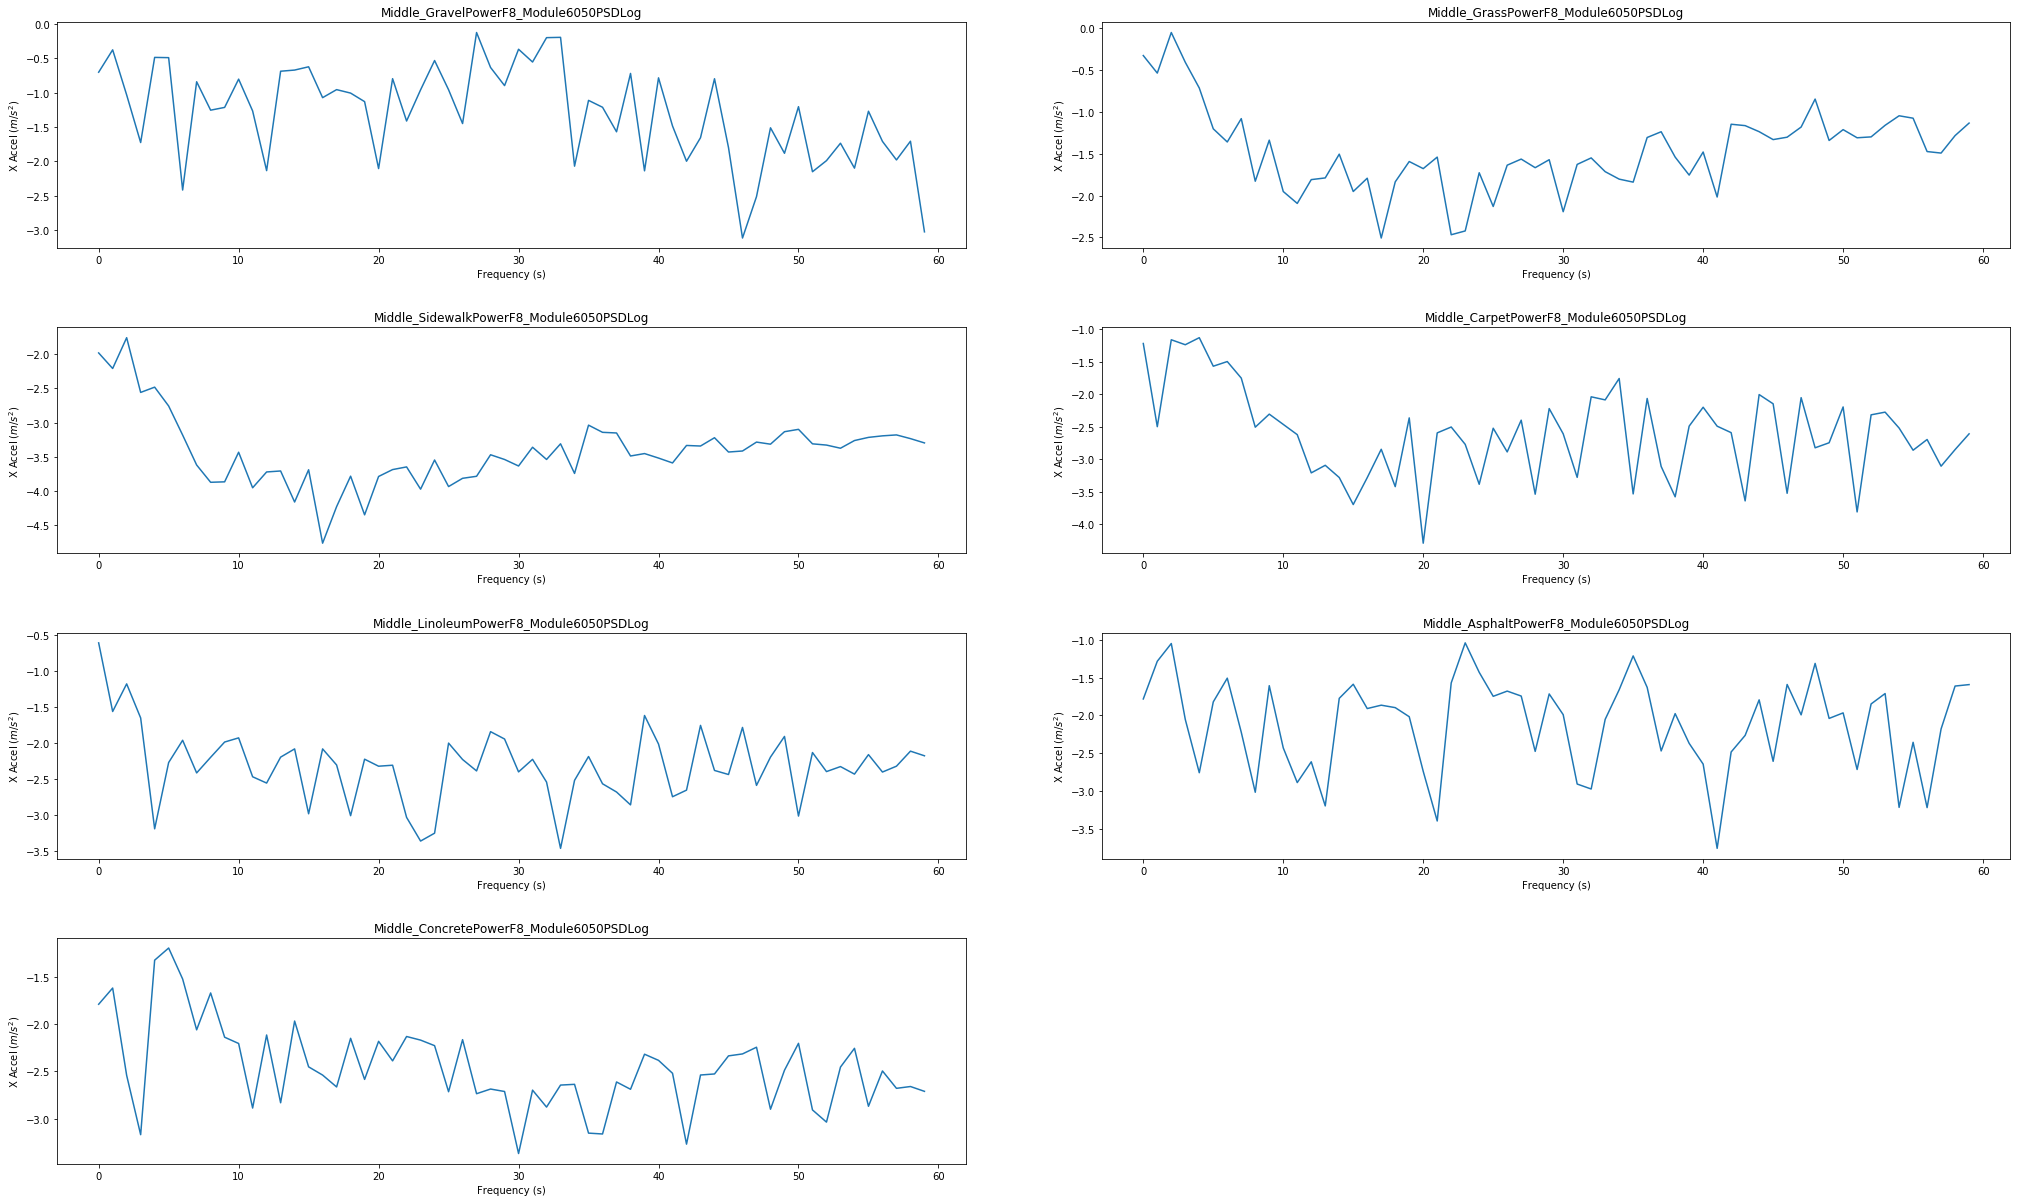

In [46]:
# Plot all PSDs of Z Accel for 0th window
plot_all(np_to_pd(psds_to_plot, windowed=True), x_axis='Frequency', y_axis='X Accel', windowed=True)

#### Data Structure:

`Labelled Terrain Dataset
-> Time Window
---> 2D NumPy Array
-----> Row = Transform Value for Frequency
-----> Col = Dirn | Frequency`

### Part (c) - 3D Visualization

In [47]:
'''Plot the set transforms in 3d'''
def plot_transforms_3d(datasets_transformed, win_num, dirn, transform_name):
    plt.clf()
    fig = plt.figure(figsize=(10, 8))
    ax = fig.gca(projection='3d')
    
    # Specific to FFT or PSD
    if transform_name == 'FFT':
        z_lim = (0, 1.6)
        ax.set_zlim(z_lim[0], z_lim[1])
        ax.set_zlabel('Amplitude (Normalized to Window Size)')
        
    elif transform_name == 'PSD':
        z_lim = (-10, -30)
        ax.set_zlim(z_lim[0], z_lim[1])
        ax.set_zlabel('Amplitude (Log-Scaled)')
    
    n_datasets = len(datasets_transformed)
    
    # Change y axis to corespond with terrain labels
    ax.set_ylim(0.5, n_datasets+0.5)
    subset = np.arange(0, n_datasets, dtype=int)
    ax.set_yticks(np.add(subset, 1.5))
    y_labels = [get_terrain_name(get_terrain_num(key)) for key in datasets_transformed.keys()]
    ax.set_yticklabels(y_labels)
    
    ax.set_xlabel('Frequency ($Hz$)')
    
    # Bar graph paremeters
    width = depth = 0.75
    
    # TODO: Sort by max amplitude
    # Plot each dataset FFT
    for i, (label, dataset) in enumerate(datasets_transformed.items()):
        # To plot
        x = dataset[win_num][:, -1]
        y = [i+1]
        top = dataset[win_num][:, dirn]
        
        # Specific to transform
        bot = np.full(top.shape, z_lim[0])
        ax.bar3d(x, y, bot, width, depth, top, alpha=0.8)
        
        # TODO: Make this nicer
        ax.set_title(transform_name + ' of ' + get_columns(label)[dirn] + ', Window {}')
    
    plt.show()

<Figure size 432x288 with 0 Axes>

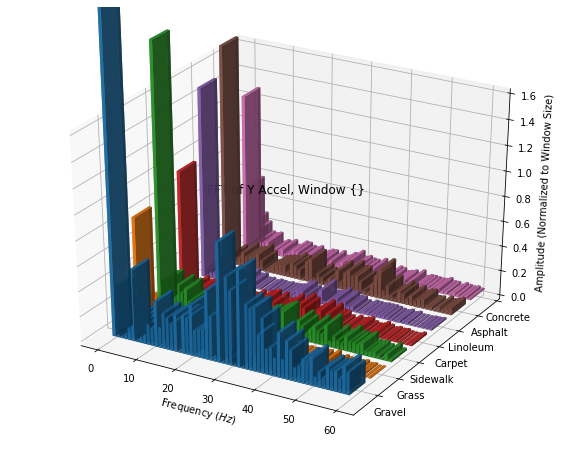

In [48]:
# Plot 3D Z Accel FFT of 0th window
ffts_to_plot = {label: dataset for label, dataset in datasets_fft.items() if 'Middle' in label and 'Straight' not in label and 'Donut' not in label}
plot_transforms_3d(ffts_to_plot, win_num=4, dirn=1, transform_name='FFT')

<Figure size 432x288 with 0 Axes>

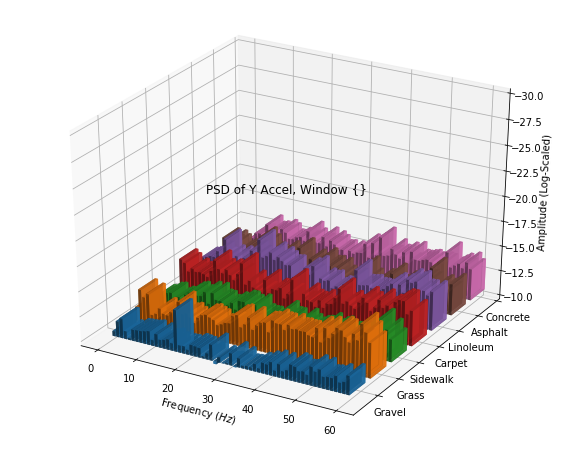

In [49]:
# Plot 3D Z Accel PSD of 0th window
psds_to_plot = {label: dataset for label, dataset in datasets_psd_log.items() if 'Middle' in label and 'Straight' not in label and 'Donut' not in label }
plot_transforms_3d(psds_to_plot, win_num=4, dirn=1, transform_name='PSD')

### Part (d) - Spectograms

In [50]:
'''Plot a spectogram of data'''
def plot_spectogram(set_label, dirn, size):
    # Get sampling frequency for label
    f_samp, f_low, f_high = get_frequencies(set_label)
    
    plt.clf()
    plt.figure(figsize=(12, 8))
    
    # Compute spectogram directly using time series data
    plt.specgram(datasets[set_label][:, dirn], NFFT=size, Fs=f_samp)
    plt.title('Spectrogram of {} for {}'.format(get_columns(set_label)[dirn], set_label))
    plt.xlabel('Data Window')
    plt.xticks(label=np.arange(0, len(datasets_windowed[set_label])))
    plt.ylabel('Frequency ($Hz$)')
    
    plt.show()

<Figure size 432x288 with 0 Axes>

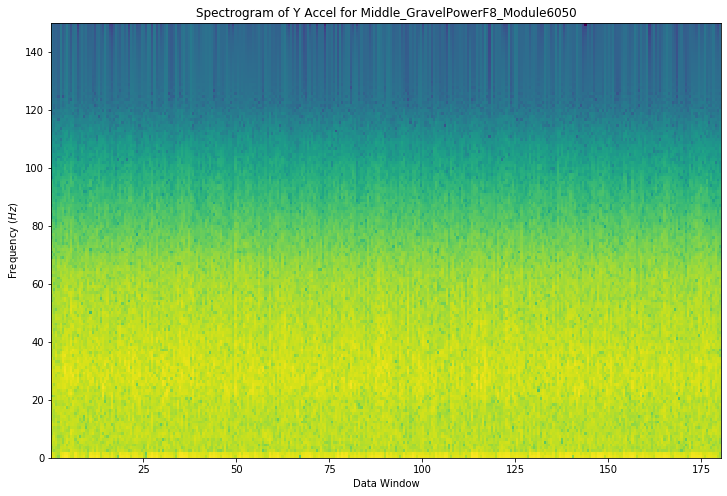

In [51]:
plot_spectogram(dataset_labels[0], dirn=1, size=get_window_size(dataset_labels[0]))

## Part 5 - Feature Extraction

#### Extract possibly relevant features (e.g. Mean, Min, Skew) from each data window

In [52]:
# Feature extraction functions

# For small float values
EPSILON = 0.00001

'''L2 norm of an array'''
def l2norm(array):
    return np.linalg.norm(array, ord=2)

'''Correlation of an array with itself'''
def autocorr(array):
    return np.correlate(array, array)[0]

'''Root mean squared of an array'''
def rms(array):
    return np.sqrt(np.mean(array ** 2))

'''Zero crossing rate of an array as a fraction of total size of array'''
def zcr(array):
    # Locations where array > 0, put -1 and 1 for rising/falling,
    # divide by total datapoints
    return len(np.nonzero(np.diff(array > 0))[0]) / len(array)

'''Mean square frequency'''
def msf(freqs, psd_amps):
    num = np.sum(np.multiply(np.resize(freq, len(psd_amps)), np.power(psd_amps, 2)))
    denom = np.sum(psd_amps)
    
    # In case zero amplitude transform is ecountered
    if denom <= EPSILON:
        return EPSILON
    
    return np.divide(num, denom)

'''Root mean square frequency'''
def rmsf(freqs, psd_amps):
    return np.sqrt(msf(freqs, psd_amps))

'''Frequency center'''
def fc(freqs, psd_amps):
    num = np.sum(np.multiply(np.resize(freq, len(psd_amps)), psd_amps))
    denom = np.sum(psd_amps)
    
    # In case zero amplitude transform is ecountered
    if denom <= EPSILON:
        return EPSILON
    
    return np.divide(num, denom)

'''Variance frequency'''
def vf(freqs, psd_amps):
    return msf(freqs, psd_amps) - fc(freqs, psd_amps) ** 2

'''Root variance frequency'''
def rvf(freqs, psd_amps):
    return np.sqrt(msf(freqs, psd_amps))

In [53]:
'''Extract given features from everything in dataset'''
def feature_all(features, datasets, regular=True):
    datasets_feat = {}
    
    # Calculate features for each window of each column of each dataset
    for label, dataset in datasets.items():
        directions = {}
        n_data_col = get_n_data_col(label)
        
        # Loop over data columns
        for i, direction in enumerate(get_columns(label)[:n_data_col]):
            feats = {}
            
            if (regular):
                '''Execute a function over all windows'''
                def function_all_windows(function):
                    feat_in_window = []
                    
                    for window in dataset:
                        feat_in_window.append(function(window[:, i]))
                    
                    return feat_in_window
                    
            else:
                '''Alternate defintion for frequency functions'''
                def function_all_windows(function):
                    feat_in_window = []
                    
                    for window in dataset:
                        feat_in_window.append(function(window[:, -1], window[:, i]))
                    
                    return feat_in_window
                    
                    
            # Execute every function over all windows    
            for feat_name, feat_func in features.items():
                feats.update({feat_name: function_all_windows(feat_func)})
            
            directions.update({direction: pd.DataFrame.from_dict(feats)})

        datasets_feat.update({label.replace('PSD', ''): directions})
    
    return datasets_feat

In [54]:
'''Plot a feature on all terrains for each time window'''
def plot_set_features(datasets_feat, dirn, feat_name, placement_name, ylim=None, xlim=None):
    plt.clf()
    plt.figure(figsize=(10,8))
    
    for label, dataset in datasets_feat.items():
        plt.plot(dataset[dirn][feat_name], label=label)
        
    if ylim is not None:
        plt.ylim(ylim[0], ylim[1])
    if xlim is not None:
        plt.xlim(xlim[0], xlim[1])
    
    plt.ylabel(feat_name)
    plt.xlabel('Window #')
    plt.title(placement_name + ' ' + dirn)
    plt.legend()
    plt.show()

### Part (a) - Time Domain Features

In [55]:
# Time domain feature functions and names
time_features = {'Mean': np.mean, 'Std Dev': np.std,  'L2 Norm': l2norm, 'Autocorrelation': autocorr, 
                 'Max': np.amax, 'Min' : np.amin, 'Root Mean Squared': rms, 'Zero Crossing Rate': zcr, 
                 'Skew': stats.skew, 'Excess Kurtosis': stats.kurtosis} 

# Create array of features of each window for each dataset and direction
datasets_feat_time = feature_all(time_features, datasets_windowed)

In [56]:
# Check if its constructed correctly and print some info
print('Num datasets: {}'.format(len(datasets_feat_time)))
print('Num directions: {}'.format(len(datasets_feat_time[dataset_labels[0]])))
print('Shape of first dataset first direction: {}'.format(datasets_feat_time[dataset_labels[0]]['X Accel'].shape))

Num datasets: 21
Num directions: 6
Shape of first dataset first direction: (180, 10)


<Figure size 432x288 with 0 Axes>

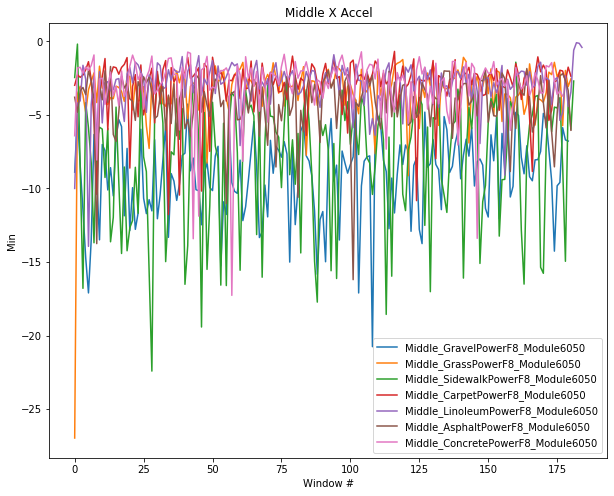

In [57]:
# Plot Min of frame Z Accel
feat_datasets_to_plot = {label: dataset for label, dataset in datasets_feat_time.items() if 'Middle' in label in label and 'Straight' not in label and 'Donut' not in label}
plot_set_features(feat_datasets_to_plot, dirn='X Accel', feat_name='Min', placement_name='Middle')

### Part (b) - Frequency Domain Features

In [58]:
# Frequency domain feature functions and names
freq_features = {'Mean Square Frequency': msf, 'Root Mean Square Frequency': rmsf, 'Frequency Center': fc, 
                 'Variance Frequency': vf, 'Root Variance Frequency': rvf}

# Create array of features of each window for each dataset and direction
datasets_feat_freq = feature_all(freq_features, datasets_psd, regular=False)

In [59]:
# Check if its constructed correctly and print some info
print('Num datasets: {}'.format(len(datasets_feat_freq)))
print('Num directions: {}'.format(len(datasets_feat_freq[dataset_labels[0]])))
print('Shape of one direction: {}'.format(datasets_feat_freq[dataset_labels[0]]['X Accel'].shape))

Num datasets: 21
Num directions: 6
Shape of one direction: (180, 5)


<Figure size 432x288 with 0 Axes>

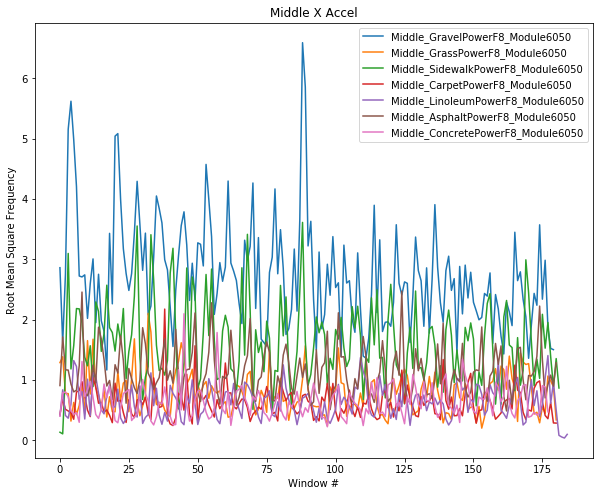

In [60]:
# Plot RMSF of Y Accel
feat_datasets_to_plot = {label: feature for label, feature in datasets_feat_freq.items() if 'Middle' in label and 'Straight' not in label and 'Donut' not in label}
plot_set_features(feat_datasets_to_plot, dirn='X Accel', feat_name='Root Mean Square Frequency', placement_name='Middle')

#### Data Structure

`Terrain Dataset Dictionary
-> Direction Dictionary 
---> Pandas Array
-----> Row = Window #
-----> Col = Extracted Feature`

## Part 6 - Standardization, Columning, and Combining Datasets

**Since Z Gyro data is often cutoff out of range on old datasets, possible to get PSD of zero which results in NaN values**

This is likely the cause of some of the errors below

In [61]:
# Convert transformed data to Pandas
datasets_fft = np_to_pd(datasets_fft, windowed=True)
datasets_psd_log = np_to_pd(datasets_psd_log, windowed=True)

In [62]:
# Run to convert transformed data back to Numpy
#datasets_fft = pd_to_np(datasets_fft, windowed=True)
#datasets_psd_log = pd_to_np(datasets_psd_log, windowed=True)

In [63]:
# Add time and frequency features together
datasets_feat = {}

for label, dataset in datasets_feat_time.items():
    dataset_feat = {}
    
    for dirn_label, dirn_df in dataset.items():
        new_df = dirn_df.join(datasets_feat_freq[label][dirn_label], how='outer')
        dataset_feat.update({dirn_label: new_df})
    
    datasets_feat.update({label: dataset_feat})

In [64]:
# Confirm formatting
datasets_feat[dataset_labels[0]]['X Accel'].head()

,Mean,Std Dev,L2 Norm,Autocorrelation,Max,Min,Root Mean Squared,Zero Crossing Rate,Skew,Excess Kurtosis,Mean Square Frequency,Root Mean Square Frequency,Frequency Center,Variance Frequency,Root Variance Frequency
0,0.518220,2.800679,49.332609,2433.706356,8.535829,-8.890125,2.848220,0.160000,-0.401659,0.895911,8.188158,2.861496,23.009915,-521.268023,2.861496
1,0.969850,2.555867,47.348916,2241.919873,10.141134,-4.871800,2.733691,0.133333,0.698425,0.753383,2.621342,1.619056,14.579263,-209.933576,1.619056
2,0.625961,2.932299,51.933241,2697.061504,10.232115,-8.444556,2.998367,0.166667,-0.021297,0.227483,7.589272,2.754863,22.186514,-484.652120,2.754863
3,0.006308,3.962791,68.637645,4711.126248,12.328514,-11.475829,3.962796,0.220000,-0.042363,0.073027,26.584317,5.155998,28.533119,-787.554537,5.155998
4,0.392901,5.017609,87.173568,7599.230957,12.708249,-14.726687,5.032968,0.200000,-0.013473,-0.230009,31.583348,5.619906,24.497533,-568.545788,5.619906


### Part (a) - Standardization

#### Standardize each feature to mean 0 and standard deviation 1. This makes feature selection and classification easier.

In [65]:
'''Normalize already featured datasets'''
def normalize_datasets(datasets, windowed=False):
    # Normalization function
    from sklearn.preprocessing import scale
    
    datasets_norm = {}
    
    # Go through windowed data (transforms) or dictionary data (features)
    for label, dataset in datasets.items():
        if windowed:
            dataset_norm = []
            for window_df in dataset:
                window_df = window_df.dropna()
                dataset_norm.append(window_df.apply(scale))
        else:
            dataset_norm = {}
            for dirn_label, dirn_df in dataset.items():
                dirn_df = dirn_df.dropna()
                dataset_norm.update({dirn_label: dirn_df.apply(sklearn.preprocessing.scale)})
        
        datasets_norm.update({label: dataset_norm})
    
    return datasets_norm

In [66]:
# So we can remove infinites
pd.set_option('use_inf_as_na', True)

datasets_feat_norm = normalize_datasets(datasets_feat)
datasets_fft_norm = normalize_datasets(datasets_fft, windowed=True)
datasets_psd_norm = normalize_datasets(datasets_psd_log, windowed=True)

In [67]:
datasets_feat_norm[dataset_labels[0]]['X Accel'].head()

,Mean,Std Dev,L2 Norm,Autocorrelation,Max,Min,Root Mean Squared,Zero Crossing Rate,Skew,Excess Kurtosis,Mean Square Frequency,Root Mean Square Frequency,Frequency Center,Variance Frequency,Root Variance Frequency
0,0.800275,-0.166242,-0.172618,-0.245499,-0.038564,0.058717,-0.172618,-1.308482,-0.814306,0.335373,-0.009551,0.149565,-0.397437,0.470291,0.149565
1,1.655331,-0.575410,-0.365850,-0.411654,0.634469,1.489416,-0.365850,-2.459499,2.226178,0.172484,-0.931980,-1.231108,-2.993039,2.516217,-1.231108
2,1.004258,0.053742,0.080709,-0.017341,0.672613,0.217359,0.080709,-1.020728,0.236963,-0.428543,-0.108787,0.031069,-0.650943,0.710911,0.031069
3,-0.168910,1.776065,1.707887,1.727551,1.551540,-0.861906,1.707887,1.281305,0.178738,-0.605064,3.038720,2.699353,1.303029,-1.279604,2.699353
4,0.563014,3.539044,3.513474,4.229669,1.710746,-2.019352,3.513474,0.418043,0.258587,-0.951390,3.867067,3.214875,0.060566,0.159606,3.214875


No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

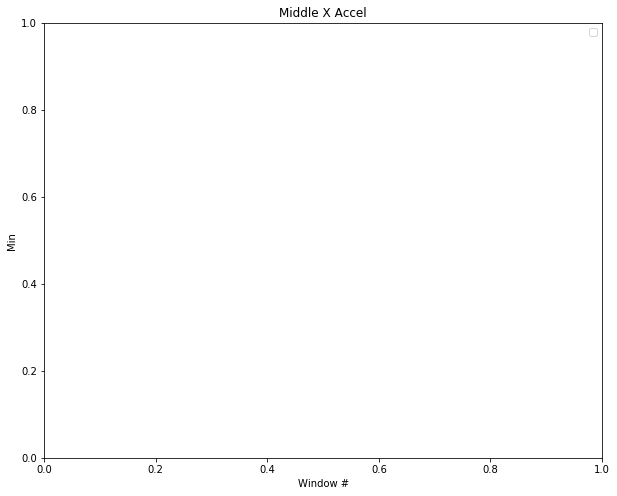

In [68]:
# Plot normalized features
feat_datasets_to_plot = {label: dataset for label, dataset in datasets_feat_norm.items() if 'Middle' in label in label and 'Straight' not in label and 'Donut' not in label}
plot_set_features(feat_datasets_to_plot, dirn='X Accel', feat_name='Min', placement_name='Middle')

/home/caris/anaconda2/envs/keenanm/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


<Figure size 432x288 with 0 Axes>

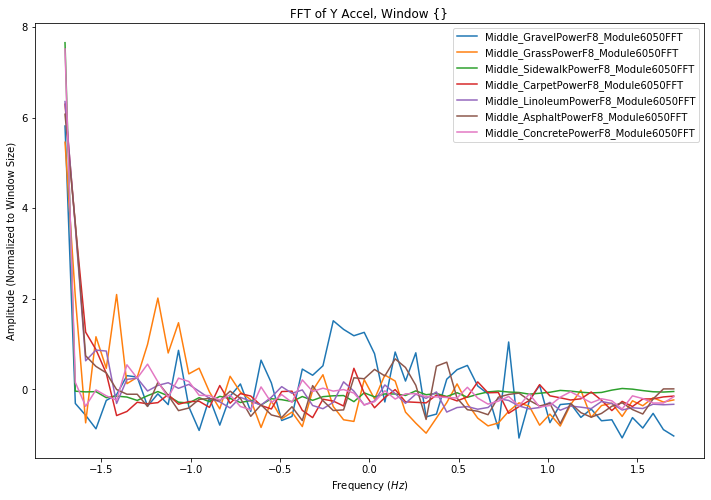

In [69]:
# Plot normalized fft
ffts_to_plot = {label: dataset for label, dataset in datasets_fft_norm.items() if 'Middle' in label and 'Straight' not in label and 'Donut' not in label}
plot_set_transforms(pd_to_np(ffts_to_plot, windowed=True), dirn=1, win_num=0, transform_name='FFT')

### Part (b) - Columning Data

#### Combine IMU data from each direction into single dataframes with columns for each feature in each direction

#### Part (i) - Extracted Featured Data

In [70]:
'''Append a tag to the end of every column name of a dataframe'''
def append_all_columns(columns, append_tag):
    new_columns = []
    
    for column in columns:
        new_columns.append(column + ' ' + append_tag)
    
    return new_columns

In [71]:
'''Combined directions of a featured dataset'''
def combine_columns(datasets):
    datasets_combined = {}
    
    for label, dataset in datasets.items():
        # Get labels array of first column
        df_combined = pd.DataFrame()
        
        # Append direction name to feature name and combine everything in one frame
        for dirn_label, dirn_df in dataset.items():
            df_copy = pd.DataFrame(dirn_df)
            
            # Add direction and placement tags
            df_copy.columns = append_all_columns(dirn_df.columns, dirn_label)
            df_copy.columns = append_all_columns(dirn_df.columns, get_placement(label))
            
            df_combined = df_combined.join(dirn_df, how='outer')
        
        datasets_combined.update({label: df_combined})
    
    return datasets_combined

In [72]:
# Take frame data and combine directions
datasets_feat_columned = combine_columns(datasets_feat_norm)

# Confirm formatting
datasets_feat_columned[dataset_labels[0]].head()

,Mean X Accel Middle,Std Dev X Accel Middle,L2 Norm X Accel Middle,Autocorrelation X Accel Middle,Max X Accel Middle,Min X Accel Middle,Root Mean Squared X Accel Middle,Zero Crossing Rate X Accel Middle,Skew X Accel Middle,Excess Kurtosis X Accel Middle,...,Min Z Gyro Middle,Root Mean Squared Z Gyro Middle,Zero Crossing Rate Z Gyro Middle,Skew Z Gyro Middle,Excess Kurtosis Z Gyro Middle,Mean Square Frequency Z Gyro Middle,Root Mean Square Frequency Z Gyro Middle,Frequency Center Z Gyro Middle,Variance Frequency Z Gyro Middle,Root Variance Frequency Z Gyro Middle
0,0.800275,-0.166242,-0.172618,-0.245499,-0.038564,0.058717,-0.172618,-1.308482,-0.814306,0.335373,...,-0.689225,0.085764,-0.393209,0.618494,0.169521,-0.561573,-0.487743,0.890900,-0.564920,-0.487743
1,1.655331,-0.575410,-0.365850,-0.411654,0.634469,1.489416,-0.365850,-2.459499,2.226178,0.172484,...,-0.490630,-1.381441,1.057152,-0.377122,-0.992529,-0.348484,-0.192581,-0.918905,0.652225,-0.192581
2,1.004258,0.053742,0.080709,-0.017341,0.672613,0.217359,0.080709,-1.020728,0.236963,-0.428543,...,0.251479,-1.420049,0.767080,1.196240,-0.836011,-0.831300,-0.956247,-0.956903,0.664086,-0.956247
3,-0.168910,1.776065,1.707887,1.727551,1.551540,-0.861906,1.707887,1.281305,0.178738,-0.605064,...,1.650123,1.524452,-0.393209,1.395660,0.167338,-0.243010,-0.061326,0.260878,0.000508,-0.061326
4,0.563014,3.539044,3.513474,4.229669,1.710746,-2.019352,3.513474,0.418043,0.258587,-0.951390,...,1.304575,2.289087,-0.393209,-0.576000,-0.623259,0.381194,0.592980,-0.196907,0.316778,0.592980


#### Part (ii) - Transformed Data

In [73]:
'''Combined direction columns for transformed data'''
def combine_transform_columns(datasets):
    combined_datasets = {}
    
    for label, dataset in datasets.items():
        combined_windows = []
        
        for window in dataset:
            window_as_row = pd.DataFrame()
            
            # Turn each window 2D dataframe into a single row dataframe
            for row in window.iterrows():
                for data_column in get_columns(label)[:get_n_data_col(label)]:
                    combined_column_name = get_transform(label) + ' {} Hz '.format(round(row[1]['Frequency']))
                    combined_column_name +=  data_column + ' ' + get_placement(label)
                    window_as_row.insert(0, combined_column_name, [row[1][data_column]])
            
            combined_windows.append(window_as_row)
        
        # Combine all the single row dataframes into one dataframe
        combined_datasets.update({label: pd.concat(combined_windows, ignore_index=True)})
    
    return combined_datasets

In [74]:
datasets_fft_columned = combine_transform_columns(datasets_fft)

In [75]:
datasets_psd_log_columned = combine_transform_columns(datasets_psd_log)

In [76]:
# Check FFT data
datasets_fft_columned[dataset_labels[0] + 'FFT']

,FFT 59.0 Hz Z Gyro Middle,FFT 59.0 Hz Y Gyro Middle,FFT 59.0 Hz X Gyro Middle,FFT 59.0 Hz Z Accel Middle,FFT 59.0 Hz Y Accel Middle,FFT 59.0 Hz X Accel Middle,FFT 58.0 Hz Z Gyro Middle,FFT 58.0 Hz Y Gyro Middle,FFT 58.0 Hz X Gyro Middle,FFT 58.0 Hz Z Accel Middle,...,FFT 1.0 Hz X Gyro Middle,FFT 1.0 Hz Z Accel Middle,FFT 1.0 Hz Y Accel Middle,FFT 1.0 Hz X Accel Middle,FFT 0.0 Hz Z Gyro Middle,FFT 0.0 Hz Y Gyro Middle,FFT 0.0 Hz X Gyro Middle,FFT 0.0 Hz Z Accel Middle,FFT 0.0 Hz Y Accel Middle,FFT 0.0 Hz X Accel Middle
0,0.000349,0.002878,0.001133,0.054410,0.023946,0.099162,0.000716,0.002856,0.003901,0.035790,...,0.011407,0.034632,0.128166,0.315330,1.161977,0.001235,0.062467,0.027379,1.017437,0.518220
1,0.003310,0.001435,0.001863,0.031474,0.023142,0.094304,0.002711,0.001455,0.003143,0.076285,...,0.021480,0.017778,0.210286,0.776981,0.389992,0.015106,0.010285,0.050800,0.409014,0.969850
2,0.005612,0.001015,0.003850,0.004153,0.102257,0.084063,0.004629,0.001138,0.002194,0.038345,...,0.020752,0.051034,0.467121,0.585904,0.254036,0.014782,0.029463,0.171628,0.512019,0.625961
3,0.004592,0.004231,0.004826,0.011626,0.051122,0.126921,0.005457,0.005637,0.007375,0.096070,...,0.013187,0.147427,0.081883,0.257148,1.723524,0.039041,0.054392,0.032588,2.084686,0.006308
4,0.003907,0.003109,0.008796,0.070277,0.180441,0.084227,0.006088,0.007018,0.014156,0.139196,...,0.006577,0.150723,0.402988,0.551643,2.007254,0.005878,0.078564,0.058171,3.075740,0.392901
5,0.003660,0.003619,0.003965,0.052614,0.034606,0.144221,0.003815,0.006342,0.009506,0.076630,...,0.030107,0.034120,0.156118,0.195475,0.039229,0.053360,0.057919,0.023507,0.663265,0.259011
6,0.003340,0.000117,0.002746,0.070909,0.057779,0.100057,0.002430,0.001987,0.005842,0.036232,...,0.003346,0.170076,0.610015,0.239097,1.209376,0.020536,0.050004,0.084897,1.267223,1.084700
7,0.002315,0.002772,0.004622,0.048801,0.084380,0.078833,0.004016,0.003326,0.006115,0.082549,...,0.010871,0.099887,0.276827,0.630087,1.655963,0.024094,0.070767,0.037553,0.822803,0.635672
8,0.003559,0.003822,0.003059,0.052316,0.115341,0.132083,0.001694,0.001493,0.006980,0.113830,...,0.018096,0.112869,0.320622,0.363959,0.827468,0.008017,0.061176,0.035887,0.876308,0.277801
9,0.002808,0.003891,0.003787,0.041644,0.046761,0.154439,0.003639,0.002229,0.002455,0.069085,...,0.079835,0.122343,0.369378,0.457905,0.472193,0.000167,0.015383,0.015905,0.675582,1.029558


In [77]:
# Check PSD data
datasets_psd_log_columned[dataset_labels[0] + 'PSDLog']

,PSD 59.0 Hz Z Gyro Middle,PSD 59.0 Hz Y Gyro Middle,PSD 59.0 Hz X Gyro Middle,PSD 59.0 Hz Z Accel Middle,PSD 59.0 Hz Y Accel Middle,PSD 59.0 Hz X Accel Middle,PSD 58.0 Hz Z Gyro Middle,PSD 58.0 Hz Y Gyro Middle,PSD 58.0 Hz X Gyro Middle,PSD 58.0 Hz Z Accel Middle,...,PSD 1.0 Hz X Gyro Middle,PSD 1.0 Hz Z Accel Middle,PSD 1.0 Hz Y Accel Middle,PSD 1.0 Hz X Accel Middle,PSD 0.0 Hz Z Gyro Middle,PSD 0.0 Hz Y Gyro Middle,PSD 0.0 Hz X Gyro Middle,PSD 0.0 Hz Z Accel Middle,PSD 0.0 Hz Y Accel Middle,PSD 0.0 Hz X Accel Middle
0,-5.073348,-4.679734,-4.158114,-2.325405,-1.545336,-3.026129,-6.613720,-4.780915,-5.590159,-2.227607,...,-3.057627,-1.404423,-1.788209,-0.375572,-2.550624,-3.528407,-3.584621,-2.620004,-1.483426,-0.701440
1,-4.738847,-4.726526,-5.097926,-2.665147,-3.289705,-2.054963,-4.659444,-5.385053,-5.158603,-2.703053,...,-3.411770,-2.078959,-1.896872,-1.448950,-0.921595,-2.691754,-3.034898,-3.199190,-1.053349,0.081851
2,-4.473891,-4.654010,-5.271807,-2.642817,-1.843707,-1.484894,-4.200799,-5.685865,-4.527995,-4.462329,...,-2.871210,-3.009532,-1.038098,-1.207638,-0.710092,-3.072904,-3.064841,-2.283242,-0.360111,-0.163317
3,-4.327917,-3.964017,-4.874365,-1.815407,-2.185659,-2.752973,-4.375035,-4.446107,-4.331850,-3.568099,...,-3.085549,-1.974249,-0.896214,-1.512416,-1.144722,-2.818926,-3.458701,-1.361816,-1.872585,-0.878604
4,-4.103718,-4.621167,-5.132481,-3.335278,-1.904125,-1.882735,-4.515214,-4.713632,-3.810356,-2.005339,...,-4.080546,-2.301271,-1.578216,-0.475123,-0.782639,-2.965035,-4.062949,-1.342608,-0.488387,-0.215654
5,-4.852329,-4.704724,-4.160153,-1.717406,-1.827309,-1.585759,-4.571959,-4.581842,-4.502376,-2.256775,...,-2.904717,-1.646545,-0.508148,-0.941376,-1.657187,-2.502014,-2.741627,-2.632958,-1.312065,-1.116787
6,-4.768530,-4.766348,-4.807064,-2.704261,-1.492492,-3.076505,-4.651465,-7.562047,-4.821504,-1.997568,...,-2.729304,-1.496680,-1.038900,-2.111383,-0.958362,-3.952592,-4.649912,-1.237686,-0.128288,-0.941822
7,-4.776019,-4.991653,-4.400216,-2.437501,-1.981772,-2.010407,-4.969989,-4.813365,-4.369365,-2.322106,...,-2.829644,-1.730586,-1.602755,-0.264947,-0.494966,-3.007302,-3.626426,-1.699949,-0.814553,-0.100169
8,-5.798414,-6.139217,-3.978438,-2.815128,-1.366608,-2.893260,-4.596253,-4.534431,-4.727894,-2.261695,...,-3.446987,-2.693901,-1.395774,-0.205419,-0.515913,-3.003141,-3.183796,-1.593820,-0.686984,-0.576864
9,-4.552491,-4.845036,-5.164526,-4.092598,-2.792286,-2.601705,-4.802067,-4.518859,-4.542370,-2.459855,...,-3.096100,-1.668852,-1.642341,-0.876439,-0.660737,-1.781043,-1.894584,-1.523813,-0.564028,-0.377419


### Part (c) - Adding Labels

Create a new column containg the an integer label for each terrain.

In [78]:
'Add labels to a dataset'
def insert_labels(datasets):
    # Returns new datasets
    datasets_copy = {}
    
    # Add to each dataframe of a dataset
    for label, dataset in datasets.items():
        terrain_num = get_terrain_num(label)
        labels = [terrain_num for _ in range(len(dataset))]
        
        dataset_copy = dataset.copy()
        dataset_copy.insert(0, 'Label', labels)
        
        datasets_copy.update({label: dataset_copy})
    
    return datasets_copy

In [79]:
# Add labels
datasets_feat_columned = insert_labels(datasets_feat_columned)
datasets_fft_columned = insert_labels(datasets_fft_columned)
datasets_psd_log_columned = insert_labels(datasets_psd_log_columned)

In [80]:
# Check labelled feature data
datasets_feat_columned[dataset_labels[0]].head()

,Label,Mean X Accel Middle,Std Dev X Accel Middle,L2 Norm X Accel Middle,Autocorrelation X Accel Middle,Max X Accel Middle,Min X Accel Middle,Root Mean Squared X Accel Middle,Zero Crossing Rate X Accel Middle,Skew X Accel Middle,...,Min Z Gyro Middle,Root Mean Squared Z Gyro Middle,Zero Crossing Rate Z Gyro Middle,Skew Z Gyro Middle,Excess Kurtosis Z Gyro Middle,Mean Square Frequency Z Gyro Middle,Root Mean Square Frequency Z Gyro Middle,Frequency Center Z Gyro Middle,Variance Frequency Z Gyro Middle,Root Variance Frequency Z Gyro Middle
0,6,0.800275,-0.166242,-0.172618,-0.245499,-0.038564,0.058717,-0.172618,-1.308482,-0.814306,...,-0.689225,0.085764,-0.393209,0.618494,0.169521,-0.561573,-0.487743,0.890900,-0.564920,-0.487743
1,6,1.655331,-0.575410,-0.365850,-0.411654,0.634469,1.489416,-0.365850,-2.459499,2.226178,...,-0.490630,-1.381441,1.057152,-0.377122,-0.992529,-0.348484,-0.192581,-0.918905,0.652225,-0.192581
2,6,1.004258,0.053742,0.080709,-0.017341,0.672613,0.217359,0.080709,-1.020728,0.236963,...,0.251479,-1.420049,0.767080,1.196240,-0.836011,-0.831300,-0.956247,-0.956903,0.664086,-0.956247
3,6,-0.168910,1.776065,1.707887,1.727551,1.551540,-0.861906,1.707887,1.281305,0.178738,...,1.650123,1.524452,-0.393209,1.395660,0.167338,-0.243010,-0.061326,0.260878,0.000508,-0.061326
4,6,0.563014,3.539044,3.513474,4.229669,1.710746,-2.019352,3.513474,0.418043,0.258587,...,1.304575,2.289087,-0.393209,-0.576000,-0.623259,0.381194,0.592980,-0.196907,0.316778,0.592980


In [81]:
# Check labelled FFT data
datasets_fft_columned[dataset_labels[0] + 'FFT'].head()

,Label,FFT 59.0 Hz Z Gyro Middle,FFT 59.0 Hz Y Gyro Middle,FFT 59.0 Hz X Gyro Middle,FFT 59.0 Hz Z Accel Middle,FFT 59.0 Hz Y Accel Middle,FFT 59.0 Hz X Accel Middle,FFT 58.0 Hz Z Gyro Middle,FFT 58.0 Hz Y Gyro Middle,FFT 58.0 Hz X Gyro Middle,...,FFT 1.0 Hz X Gyro Middle,FFT 1.0 Hz Z Accel Middle,FFT 1.0 Hz Y Accel Middle,FFT 1.0 Hz X Accel Middle,FFT 0.0 Hz Z Gyro Middle,FFT 0.0 Hz Y Gyro Middle,FFT 0.0 Hz X Gyro Middle,FFT 0.0 Hz Z Accel Middle,FFT 0.0 Hz Y Accel Middle,FFT 0.0 Hz X Accel Middle
0,6,0.000349,0.002878,0.001133,0.054410,0.023946,0.099162,0.000716,0.002856,0.003901,...,0.011407,0.034632,0.128166,0.315330,1.161977,0.001235,0.062467,0.027379,1.017437,0.518220
1,6,0.003310,0.001435,0.001863,0.031474,0.023142,0.094304,0.002711,0.001455,0.003143,...,0.021480,0.017778,0.210286,0.776981,0.389992,0.015106,0.010285,0.050800,0.409014,0.969850
2,6,0.005612,0.001015,0.003850,0.004153,0.102257,0.084063,0.004629,0.001138,0.002194,...,0.020752,0.051034,0.467121,0.585904,0.254036,0.014782,0.029463,0.171628,0.512019,0.625961
3,6,0.004592,0.004231,0.004826,0.011626,0.051122,0.126921,0.005457,0.005637,0.007375,...,0.013187,0.147427,0.081883,0.257148,1.723524,0.039041,0.054392,0.032588,2.084686,0.006308
4,6,0.003907,0.003109,0.008796,0.070277,0.180441,0.084227,0.006088,0.007018,0.014156,...,0.006577,0.150723,0.402988,0.551643,2.007254,0.005878,0.078564,0.058171,3.075740,0.392901


### Part (d) - Combining Datasets

Combine data from every dataset into rows in a single dataframe

In [82]:
'''Combine data from labelled datasets into a single dataframe'''
def combine_datasets(datasets):
    return pd.concat(list(datasets.values()), ignore_index=True)

In [83]:
# Combine all data individually
# TODO: Combine each mounting source of a single dataset into a single dataframe so we can select across all
def separate_and_combine(datasets_columned, csv_tag):
    datasets_separated = {}
    
    # Separate according to mounting location
    for placement in placements:
        datasets = {label: dataset for label, dataset in datasets_columned.items() if placement in label}
        
        # Update if not empty
        if bool(datasets): 
            datasets_separated.update({placement: datasets})
    
    # Combine each mounting into a single combined dataframe and drop NaN values, export to csv
    for placement, datasets in datasets_separated.items():
        # NaN values usually come from cutoff range of Z gyro, so drop the column
        datasets_separated.update({placement: combine_datasets(datasets).dropna(axis='columns')})
        
        # Export to a csv file
        csv_filename = 'processed_data/' + placement + '_' + csv_tag + '.csv'
        datasets_separated[placement].to_csv(csv_filename, index=False)
                        
    # Return dictionary of each mounting location
    return datasets_separated

In [84]:
# Convert features
feat_combined = separate_and_combine(datasets_feat_columned, csv_tag='Features_Filt_Keenan_Power')

feat_combined['Middle'].tail()

,Label,Mean X Accel Middle,Std Dev X Accel Middle,L2 Norm X Accel Middle,Autocorrelation X Accel Middle,Max X Accel Middle,Min X Accel Middle,Root Mean Squared X Accel Middle,Zero Crossing Rate X Accel Middle,Skew X Accel Middle,...,Min Z Gyro Middle,Root Mean Squared Z Gyro Middle,Zero Crossing Rate Z Gyro Middle,Skew Z Gyro Middle,Excess Kurtosis Z Gyro Middle,Mean Square Frequency Z Gyro Middle,Root Mean Square Frequency Z Gyro Middle,Frequency Center Z Gyro Middle,Variance Frequency Z Gyro Middle,Root Variance Frequency Z Gyro Middle
2095,0,0.061279,-1.400599,-1.516787,-1.109869,-0.346397,0.704759,-1.516787,0.430119,1.400735,...,-0.324439,-1.870623,-0.549337,-0.104725,-0.953906,-0.731013,-0.736328,-0.814337,0.660054,-0.736328
2096,0,0.247687,0.416933,0.266765,0.095467,0.300284,0.142196,0.266765,-0.973682,-0.183138,...,0.118615,-0.667149,1.196769,-0.196223,-1.150038,0.450409,0.718575,-0.648904,0.587632,0.718575
2097,0,0.470797,0.934207,0.823850,0.657702,-0.539006,-0.288248,0.823850,-1.621591,-0.869348,...,1.546926,1.093776,-0.549337,0.033306,-0.067143,-0.834556,-1.076046,-0.719877,0.618150,-1.076046
2098,0,0.712260,1.264044,1.210889,1.100372,2.022136,-0.180024,1.210889,1.078027,1.709978,...,1.375630,0.304927,-0.549337,0.382773,0.197048,-0.406839,-0.160971,1.899851,-1.892781,-0.160971
2099,0,-0.813661,0.100200,-0.116934,-0.240355,-0.273817,-0.337574,-0.116934,0.322134,-0.274995,...,-0.202087,-1.592290,1.196769,-0.788641,-0.703094,1.251483,1.296325,-0.233120,0.354408,1.296325


In [85]:
# Convert features
fft_combined = separate_and_combine(datasets_fft_columned, csv_tag='FFTs_Filt_Keenan_Power')

fft_combined['Middle'].tail()

,Label,FFT 59.0 Hz Z Gyro Middle,FFT 59.0 Hz Y Gyro Middle,FFT 59.0 Hz X Gyro Middle,FFT 59.0 Hz Z Accel Middle,FFT 59.0 Hz Y Accel Middle,FFT 59.0 Hz X Accel Middle,FFT 58.0 Hz Z Gyro Middle,FFT 58.0 Hz Y Gyro Middle,FFT 58.0 Hz X Gyro Middle,...,FFT 1.0 Hz X Gyro Middle,FFT 1.0 Hz Z Accel Middle,FFT 1.0 Hz Y Accel Middle,FFT 1.0 Hz X Accel Middle,FFT 0.0 Hz Z Gyro Middle,FFT 0.0 Hz Y Gyro Middle,FFT 0.0 Hz X Gyro Middle,FFT 0.0 Hz Z Accel Middle,FFT 0.0 Hz Y Accel Middle,FFT 0.0 Hz X Accel Middle
2095,0,0.001688,0.000514,0.000566,0.005293,0.013211,0.013494,0.001752,0.000605,0.000384,...,0.000810,0.010921,0.111401,0.063130,0.736022,0.005466,0.033808,0.003173,0.537452,0.200256
2096,0,0.006456,0.000638,0.000451,0.011752,0.023972,0.019978,0.008040,0.002120,0.002352,...,0.030495,0.102162,0.682748,0.511700,0.846672,0.035004,0.024356,0.087585,1.128968,0.270012
2097,0,0.000585,0.000655,0.000295,0.007212,0.015163,0.003418,0.000477,0.001141,0.000377,...,0.008003,0.036616,0.283715,0.388688,1.879579,0.010499,0.086980,0.018166,2.764632,0.353502
2098,0,0.000410,0.001139,0.001052,0.015246,0.017345,0.052463,0.001277,0.001237,0.001409,...,0.018948,0.075007,0.015698,0.283706,1.583065,0.019487,0.055164,0.060821,2.248782,0.443860
2099,0,0.006351,0.000377,0.001720,0.005778,0.019210,0.041650,0.006721,0.000927,0.000590,...,0.015245,0.075828,0.684480,0.421507,0.440758,0.012563,0.019284,0.048036,0.711871,0.127155


In [86]:
# Convert features
psd_log_combined = separate_and_combine(datasets_psd_log_columned, csv_tag='PSDLogs_Filt_Keenan_Power')

psd_log_combined['Middle'].tail()

,Label,PSD 59.0 Hz Z Gyro Middle,PSD 59.0 Hz Y Gyro Middle,PSD 59.0 Hz X Gyro Middle,PSD 59.0 Hz Z Accel Middle,PSD 59.0 Hz Y Accel Middle,PSD 59.0 Hz X Accel Middle,PSD 58.0 Hz Z Gyro Middle,PSD 58.0 Hz Y Gyro Middle,PSD 58.0 Hz X Gyro Middle,...,PSD 1.0 Hz X Gyro Middle,PSD 1.0 Hz Z Accel Middle,PSD 1.0 Hz Y Accel Middle,PSD 1.0 Hz X Accel Middle,PSD 0.0 Hz Z Gyro Middle,PSD 0.0 Hz Y Gyro Middle,PSD 0.0 Hz X Gyro Middle,PSD 0.0 Hz Z Accel Middle,PSD 0.0 Hz Y Accel Middle,PSD 0.0 Hz X Accel Middle
2095,0,-5.316292,-6.682995,-6.187085,-4.120410,-3.776622,-4.353039,-5.244238,-6.277535,-6.193948,...,-5.318476,-2.902565,-2.215151,-1.907017,-1.421326,-4.318293,-5.882264,-3.622467,-1.605193,-2.098499
2096,0,-4.209507,-6.785662,-5.584024,-4.182247,-4.965492,-3.566484,-4.079083,-6.089732,-6.391123,...,-3.377894,-2.149582,-0.838153,-1.533759,-0.229075,-3.299764,-2.730500,-1.680395,-0.030449,-0.280938
2097,0,-6.456510,-5.933004,-6.262268,-5.101679,-3.974960,-3.389265,-6.165226,-6.066586,-6.760080,...,-3.784999,-1.855709,-1.811087,-1.186599,-1.963742,-3.791521,-3.892425,-2.571628,-0.793205,-0.519768
2098,0,-5.513697,-6.409816,-5.765044,-3.484951,-3.819729,-2.713704,-6.474416,-5.586061,-5.654832,...,-3.063889,-2.137768,-1.902958,-1.095216,-3.208072,-3.067583,-3.143849,-1.948768,-3.307292,-0.793233
2099,0,-4.137837,-6.043596,-5.416682,-3.365639,-3.220624,-2.960654,-4.093341,-6.546450,-5.227712,...,-3.263068,-1.992492,-0.810386,-2.097487,-0.424594,-3.520702,-3.332735,-1.939305,-0.028248,-0.449360


### Glossary

`Dataset` - Batch of data recorded on one terrain type

`Data Window` - Split up portion of a `Dataset`

`Direction / Axes` - Linear acceleration or gyroscope in $x,y$ or $z$

`Feature Vector` - Any feature of the data that can be used to classify terrain, e.g. Z Accel Mean, Y Accel FFT, etc

`Extracted Feature Vector` - Features that aren't from transforms, e.g. Z Accel Min, Y Accel Autocorrelation, etc

`Placement` - One of three IMU placements on the wheelchair, i.e. Middle, Left, or Right